# Maple et al., 2025 Figure 2B and calculating *FLC* mRNA decay rates from smFISH data

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc 
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import statsmodels.api as sm
import statsmodels.formula.api as smf
import nestle
import corner 

rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

## Import data (counts per unit area per cell) from Excel file for smFISH Expt 1

In [2]:
file_path = 'FLC_mRNA_ActD_Decay_Exp1_Dataset.xlsx'
df = pd.read_excel(file_path, sheet_name='Final Summary', engine='openpyxl')

# Extract the first 5 columns to make the NV data table
NV_df = df.iloc[:, 0:5]

# Extract the last 5 columns to make the W2 data table
W2_df = df.iloc[:, 5:]


## Make the plot

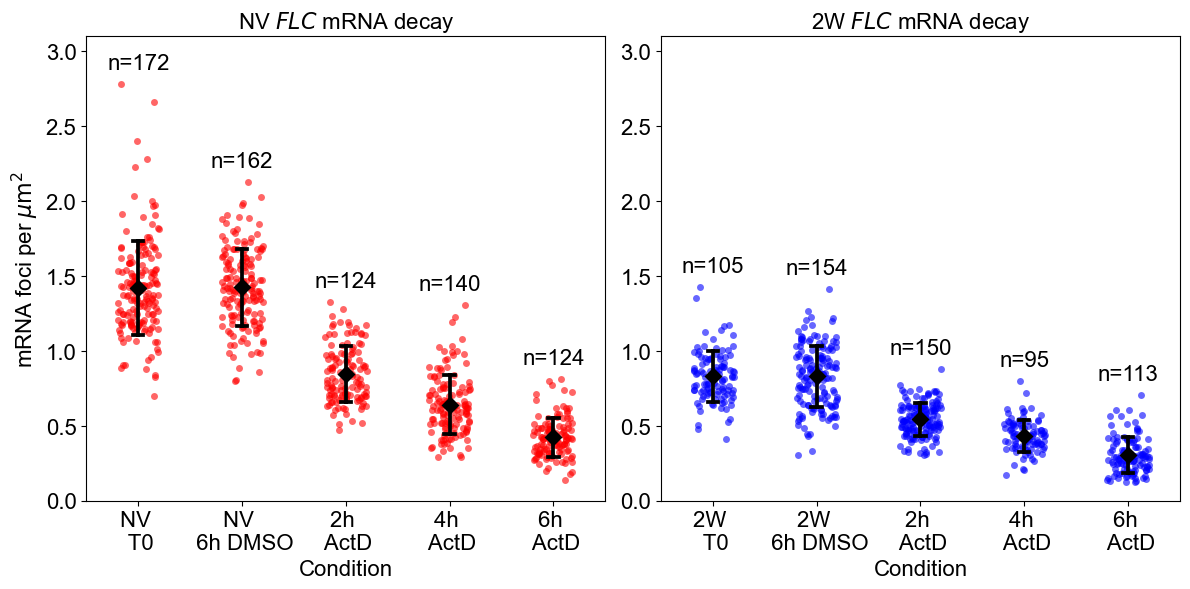

In [3]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.stripplot(data=NV_df, color='red', jitter=0.2, size=5, alpha=0.6, zorder=1)  # Lower zorder
sns.pointplot(data=NV_df, color='black', errorbar='sd', capsize=0.1, markers='D', linestyle='none', zorder=2)  # Higher zorder
# Add annotations for the number of data points
for i, col in enumerate(NV_df.columns):
    count = NV_df[col].dropna().shape[0]  # Count non-NaN values
    plt.text(i, NV_df[col].max() + 0.1, f'n={count}', ha='center', fontsize=16, color='black')
#Set xtick labels
plt.xticks([0, 1, 2, 3, 4], ['NV \n T0', 'NV \n 6h DMSO',  '2h \n ActD', '4h \n ActD', '6h \n ActD'])
plt.ylabel(r'mRNA foci per $\mu \mathrm{m}^2$', fontsize=16)
plt.xlabel('Condition', fontsize=16)
plt.title(r'NV $\mathit{FLC}$ mRNA decay', fontsize=16)
#Set y-axis limits
plt.ylim(0, 3.1)
#Set xtick label size
plt.xticks(fontsize=16)
#Set ytick label size
plt.yticks(fontsize=16)
#Set yticks
# plt.yticks(np.arange(0, 1.6, 0.5))

plt.subplot(1, 2, 2)
sns.stripplot(data=W2_df, color='blue', jitter=0.2, size=5, alpha=0.6, zorder=1)  # Lower zorder
sns.pointplot(data=W2_df, color='black', errorbar='sd', capsize=0.1, markers='D', linestyle='none', zorder=2)  # Higher zorder
# Add annotations for the number of data points
for i, col in enumerate(W2_df.columns):
    count = W2_df[col].dropna().shape[0]  # Count non-NaN values
    plt.text(i, W2_df[col].max() + 0.1, f'n={count}', ha='center', fontsize=16, color='black')
#Set xtick labels
plt.xticks([0, 1, 2, 3, 4], ['2W \n T0', '2W \n 6h DMSO', '2h \n ActD', '4h \n ActD', '6h \n ActD'])
# plt.ylabel(r'mRNA foci per $\mu \mathrm{m}^2$', fontsize=16)
plt.xlabel('Condition', fontsize=16)
plt.title(r'2W $\mathit{FLC}$ mRNA decay', fontsize=16)
#Set xtick label size
plt.xticks(fontsize=16)
#Set ytick label size
plt.yticks(fontsize=16)
#Set yticks
# plt.yticks(np.arange(0, 1.6, 0.5))
plt.tight_layout()

#Set y-axis limits
plt.ylim(0, 3.1) # Set the y-axis limits to be the same for both plots

plt.savefig('FLC_smFISH_decayplot_combined_v2.pdf')

plt.show()



## Fit exponential decay models to the NV data and 2W data (Expt 1) and perform ANCOVA + statistical test to compare decay rates at NV and 2W

Exponential decay fit results for NV:
Decay constant (k): 0.1792 ± 0.0090
Half-life: 3.8687 ± 0.1952
Intercept: 0.1884 ± 0.0389
Exponential decay fit results for W2:
Decay constant (k): 0.1589 ± 0.0092
Half-life: 4.3622 ± 0.2516
Intercept: -0.2953 ± 0.0381


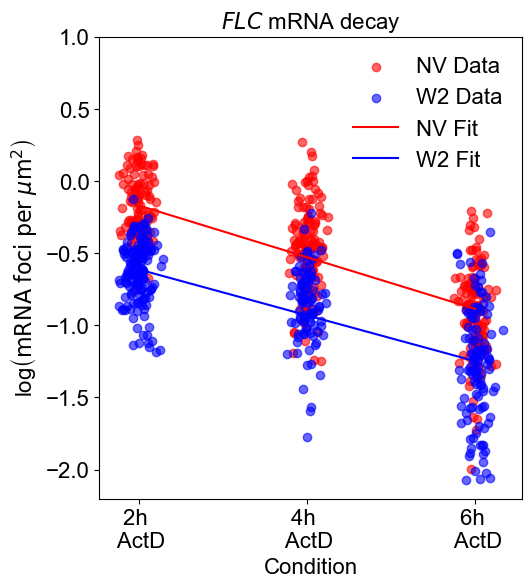

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.571    
Dependent Variable: log_data         AIC:                272.7819 
Date:               2025-10-17 12:23 BIC:                291.2408 
No. Observations:   746              Log-Likelihood:     -132.39  
Df Model:           3                F-statistic:        331.5    
Df Residuals:       742              Prob (F-statistic): 1.69e-136
R-squared:          0.573            Scale:              0.083947 
------------------------------------------------------------------
                   Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept          0.1884   0.0396   4.7539 0.0000  0.1106  0.2662
group[T.W2]       -0.4837   0.0545  -8.8750 0.0000 -0.5907 -0.3767
time              -0.1792   0.0092 -19.4765 0.0000 -0.1972 -0.1611
time:group[T.W2]   0.0203   0.0129   1.5750 0.1157 -0.0050  0.0455
-------------

In [4]:
# Fit an exponential decay model to the NV data
# Extract the non-NaN values for the 2h time point into an array
NV_2h = NV_df.iloc[:, 2].dropna().values
# Extract the non-NaN values for the 4h time point into an array
NV_4h = NV_df.iloc[:, 3].dropna().values
# Extract the non-NaN values for the 6h time point into an array
NV_6h = NV_df.iloc[:, 4].dropna().values
# Combine the arrays into a single vertical array
NV_data = np.concatenate((NV_2h, NV_4h, NV_6h))
# Create an array of time points corresponding to the data
time_points = np.concatenate((np.full(NV_2h.shape, 2), np.full(NV_4h.shape, 4), np.full(NV_6h.shape, 6)))
ones_array = np.ones(NV_data.shape)
# Make a linear fit to the log of the data
log_data = np.log(NV_data)
X = np.column_stack((ones_array,time_points))
NV_x = time_points
NV_y = log_data
# Create an array with the label 'NV' repeated for the length of the data
NV_group = np.full(NV_data.shape, 'NV')
# Combine the data into a DataFrame
NV_df_combined = pd.DataFrame({'time': NV_x, 'log_data': NV_y, 'group': NV_group})

# Perform the linear regression
from numpy.linalg import lstsq, inv

# Fit the data
A, residuals, rank, s = lstsq(X, log_data, rcond=None)

# Extract the slope and intercept
slope = A[1]
intercept = A[0]

# Calculate the decay constant and half-life
decay_constant = -slope
half_life = np.log(2) / decay_constant

# Estimate the covariance matrix
# Covariance matrix = (X^T * X)^(-1) * residual_variance
residual_variance = np.sum((log_data - (X @ A))**2) / (len(log_data) - len(A))  # Variance of residuals
cov_matrix = inv(X.T @ X) * residual_variance

# Standard errors of the parameters
slope_error = np.sqrt(cov_matrix[1, 1])
intercept_error = np.sqrt(cov_matrix[0, 0])
half_life_error = np.log(2) / (decay_constant**2) * slope_error

NV_intercept = intercept
NV_slope = slope

# Print the results with error bars
print("Exponential decay fit results for NV:")
print(f"Decay constant (k): {decay_constant:.4f} ± {slope_error:.4f}")
print(f"Half-life: {half_life:.4f} ± {half_life_error:.4f}")
print(f"Intercept: {intercept:.4f} ± {intercept_error:.4f}")


# Fit an exponential decay model to the W2 data
# Extract the non-NaN values for the 2h time point into an array
W2_2h = W2_df.iloc[:, 2].dropna().values
# Extract the non-NaN values for the 4h time point into an array
W2_4h = W2_df.iloc[:, 3].dropna().values
# Extract the non-NaN values for the 6h time point into an array
W2_6h = W2_df.iloc[:, 4].dropna().values
# Combine the arrays into a single vertical array
W2_data = np.concatenate((W2_2h, W2_4h, W2_6h))
# Create an array of time points corresponding to the data
time_points = np.concatenate((np.full(W2_2h.shape, 2), np.full(W2_4h.shape, 4), np.full(W2_6h.shape, 6)))
ones_array = np.ones(W2_data.shape)
# Make a linear fit to the log of the data
log_data = np.log(W2_data)
X = np.column_stack((ones_array,time_points))
W2_x = time_points
W2_y = log_data
# Create an array with the label 'W2' repeated for the length of the data
W2_group = np.full(W2_data.shape, 'W2')
# Combine the data into a DataFrame
W2_df_combined = pd.DataFrame({'time': W2_x, 'log_data': W2_y, 'group': W2_group})
# Perform the linear regression
from numpy.linalg import lstsq, inv
# Fit the data
A, residuals, rank, s = lstsq(X, log_data, rcond=None)
# Extract the slope and intercept
slope = A[1]
intercept = A[0]
# Calculate the decay constant and half-life
decay_constant = -slope
half_life = np.log(2) / decay_constant
# Estimate the covariance matrix
# Covariance matrix = (X^T * X)^(-1) * residual_variance
residual_variance = np.sum((log_data - (X @ A))**2) / (len(log_data) - len(A))  # Variance of residuals
cov_matrix = inv(X.T @ X) * residual_variance
# Standard errors of the parameters
slope_error = np.sqrt(cov_matrix[1, 1])
intercept_error = np.sqrt(cov_matrix[0, 0])
half_life_error = np.log(2) / (decay_constant**2) * slope_error
# Print the results with error bars
print("Exponential decay fit results for W2:")
print(f"Decay constant (k): {decay_constant:.4f} ± {slope_error:.4f}")
print(f"Half-life: {half_life:.4f} ± {half_life_error:.4f}")
print(f"Intercept: {intercept:.4f} ± {intercept_error:.4f}")

W2_intercept = intercept
W2_slope = slope

# Add jitter to NV_x and W2_x
jitter_strength = 0.1  # Adjust this value to control the amount of jitter
NV_x_jittered = NV_x + np.random.normal(0, jitter_strength, size=NV_x.shape)
W2_x_jittered = W2_x + np.random.normal(0, jitter_strength, size=W2_x.shape)

# Plot the fitted exponential decay curves for NV and W2 in the same plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(NV_x_jittered, NV_y, color='red', label='NV Data', alpha=0.6)
plt.scatter(W2_x_jittered, W2_y, color='blue', label='W2 Data', alpha=0.6)
plt.plot(NV_x, NV_intercept + NV_slope * NV_x, color='red', label='NV Fit')
plt.plot(W2_x, W2_intercept + W2_slope * W2_x, color='blue', label='W2 Fit')
# Set y-axis limits
plt.ylim(-2.2, 1)
# Add legend without a box
plt.legend(loc='upper right', fontsize=16, frameon=False)

#Set xtick labels
plt.xticks([2, 4, 6], ['2h \n ActD', '4h \n ActD', '6h \n ActD'], fontsize=16)
plt.ylabel(r'log$ \left( \mathrm{mRNA \;foci \;per} \; \mu \mathrm{m}^2 \right)$', fontsize=16)
plt.xlabel('Condition', fontsize=16)
plt.title(r'$\mathit{FLC}$ mRNA decay', fontsize=16)
#Set y-axis tick label size
plt.yticks(fontsize=16)
# Save the plot
plt.savefig('FLC_smFISH_decayplot_combined_v2_fit.pdf',bbox_inches='tight')
plt.show()




# Statistical comparison of NV and 2W fits
# Combine the two DataFrames
combined_df = pd.concat([NV_df_combined, W2_df_combined], ignore_index=True)
# Fit a linear model with interaction term
model = smf.ols('log_data ~ time * group', data=combined_df).fit()

# Print the summary of the model with more decimal places
print(model.summary2(float_format="%.5f"))
# Print the model summary to a text file
with open('FLC_smFISH_decay_model_summary.txt', 'w') as f:
    f.write(model.summary().as_text())



## Import and plot FLC data (counts per unit area per cell) from Excel file for smFISH Expt 2

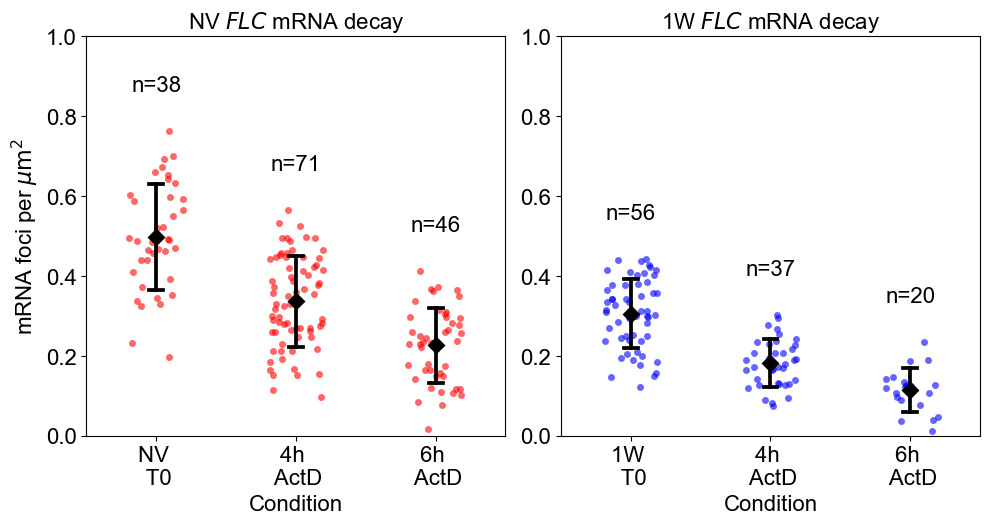

In [4]:
# Import data (counts per unit area per cell) from Excel file for smFISH Expt 2
file_path = 'FLC_mRNA_ActD_Decay_Exp2_Dataset.xlsx'
df_flc = pd.read_excel(file_path, sheet_name='FLC Summary', engine='openpyxl')
# Extract the first 3 columns to make the NV data table
NV_df_flc = df_flc.iloc[:, 0:3]
# Extract the last 3 columns to make the W2 data table (NOTE THESE ARE 1W DATA IN EXP2)
W2_df_flc = df_flc.iloc[:, 3:]

# Plot the data
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.stripplot(data=NV_df_flc, color='red', jitter=0.2, size=5, alpha=0.6, zorder=1)  # Lower zorder
sns.pointplot(data=NV_df_flc, color='black', errorbar='sd', capsize=0.1, markers='D', linestyle='none', zorder=2)  # Higher zorder
# Add annotations for the number of data points
for i, col in enumerate(NV_df_flc.columns):
    count = NV_df_flc[col].dropna().shape[0]  # Count non-NaN values
    plt.text(i, NV_df_flc[col].max() + 0.1, f'n={count}', ha='center', fontsize=16, color='black')
#Set xtick labels
plt.xticks([0, 1, 2], ['NV \n T0', '4h \n ActD', '6h \n ActD'])
plt.ylabel(r'mRNA foci per $\mu \mathrm{m}^2$', fontsize=16)
plt.xlabel('Condition', fontsize=16)
plt.title(r'NV $\mathit{FLC}$ mRNA decay', fontsize=16)
#Set y-axis limits
plt.ylim(0, 1)
#Set xtick label size
plt.xticks(fontsize=16)
#Set ytick label size
plt.yticks(fontsize=16)
#Set yticks
# plt.yticks(np.arange(0, 1.6, 0.5))    
plt.subplot(1, 2, 2)
sns.stripplot(data=W2_df_flc, color='blue', jitter=0.2, size=5, alpha=0.6, zorder=1)  # Lower zorder
sns.pointplot(data=W2_df_flc, color='black', errorbar='sd', capsize=0.1, markers='D', linestyle='none', zorder=2)  # Higher zorder
# Add annotations for the number of data points
for i, col in enumerate(W2_df_flc.columns):
    count = W2_df_flc[col].dropna().shape[0]  # Count non-NaN values
    plt.text(i, W2_df_flc[col].max() + 0.1, f'n={count}', ha='center', fontsize=16, color='black')
#Set xtick labels
plt.xticks([0, 1, 2], ['1W \n T0', '4h \n ActD', '6h \n ActD'])
# plt.ylabel(r'mRNA foci per $\mu \mathrm{m}^2$', fontsize=16)  
plt.xlabel('Condition', fontsize=16)
plt.title(r'1W $\mathit{FLC}$ mRNA decay', fontsize=16)
#Set xtick label size
plt.xticks(fontsize=16)
#Set ytick label size
plt.yticks(fontsize=16)
#Set yticks
# plt.yticks(np.arange(0, 1.6, 0.5))
plt.tight_layout()
#Set y-axis limits
plt.ylim(0, 1) # Set the y-axis limits to be the same for both plots
plt.savefig('FLC_smFISH_decayplot_combined_Exp2_v2.pdf')
plt.show()

## Estimate Expt2 FLC decay rates by nested sampling

### First for the NV data

it= 67065 logz=92.4146370535niter: 67066
ncall: 179535
nsamples: 77066
logz: 92.838 +/-  0.022
h:  4.829
a =  0.78 +/-  0.13
k =  0.21 +/-  0.04
Half-life =  3.35 +/-  0.59


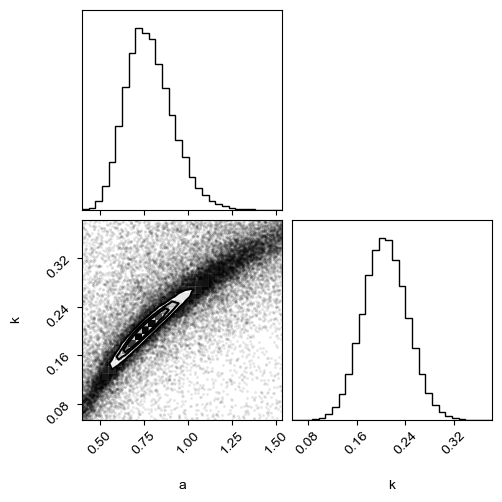

In [6]:
# Fit an exponential decay model to the NV data using nestle for Bayesian inference
# Extract the non-NaN values for the 0h time point into an array
NV_T0 = NV_df_flc.iloc[:, 0].dropna().values
# Extract the non-NaN values for the 4h time point into an array
NV_4h = NV_df_flc.iloc[:, 1].dropna().values
# Extract the non-NaN values for the 6h time point into an array
NV_6h = NV_df_flc.iloc[:, 2].dropna().values

# Combine the arrays into a single vertical array
NV_data = np.concatenate((NV_4h, NV_6h))
# Create an array of time points corresponding to the data
time_points = np.concatenate((np.full(NV_4h.shape, 4), np.full(NV_6h.shape, 6)))

def model1(theta, x):
    a, k = theta
    return a * np.exp(-k * x)



# Define x, y, and yerr for NV data
x = time_points
y = NV_data
# Estimate yerr as the standard deviation at each time point
yerr = np.zeros_like(y)
for t in np.unique(x):  
    mask = x == t
    yerr[mask] = np.std(y[mask])
# Avoid division by zero
yerr[yerr == 0] = np.mean(yerr[yerr > 0])

# Define the log-likelihood function
def log_likelihood(theta):
    a, k = theta
    model_y = model1(theta, x)
    return -0.5 * np.sum(((y - model_y) / yerr) ** 2 + np.log(2 * np.pi * yerr ** 2))
# Defines a flat prior in 0 < m < 1, 0 < a < 2:
def prior_transform(theta):
    return np.array([2., 1.]) * theta
ndim = 2  # number of parameters
res = nestle.sample(log_likelihood, prior_transform, ndim, method='single',
                    npoints=10000, callback=nestle.print_progress)
print(res.summary())
# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)

print("a = {0:5.2f} +/- {1:5.2f}".format(p[0], np.sqrt(cov[0, 0])))
print("k = {0:5.2f} +/- {1:5.2f}".format(p[1], np.sqrt(cov[1, 1])))
# Compute the half-life and its error
decay_constant = p[1]
half_life = np.log(2) / decay_constant
half_life_error = np.log(2) / (decay_constant**2) * np.sqrt(cov[1, 1])
print("Half-life = {0:5.2f} +/- {1:5.2f}".format(half_life, half_life_error))
#%% Plot the corner plot for the parameters
fig = corner.corner(res.samples, weights=res.weights, labels=['a', 'k'],
                    range=[0.9999, 0.99999], bins=30)

### Now for the 1W cold treated data

it= 62752 logz=76.8614025200niter: 62753
ncall: 220469
nsamples: 72753
logz: 77.281 +/-  0.021
h:  4.340
a =  0.54 +/-  0.16
k =  0.26 +/-  0.06
Half-life =  2.65 +/-  0.64


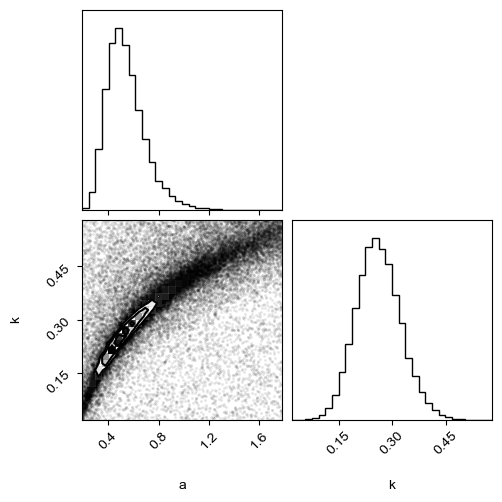

In [ ]:
# Fit an exponential decay model to the W2 data using nestle for Bayesian inference
# Extract the non-NaN values for the 0h time point into an array (NOTE THESE ARE 1W DATA IN EXP2)
W2_T0 = W2_df_flc.iloc[:, 0].dropna().values
# Extract the non-NaN values for the 4h time point into an array
W2_4h = W2_df_flc.iloc[:, 1].dropna().values
# Extract the non-NaN values for the 6h time point into an array
W2_6h = W2_df_flc.iloc[:, 2].dropna().values    
# Combine the arrays into a single vertical array
W2_data = np.concatenate((W2_4h, W2_6h))
# Create an array of time points corresponding to the data
time_points = np.concatenate((np.full(W2_4h.shape, 4), np.full(W2_6h.shape, 6)))   
# Define x, y, and yerr for W2 data
x = time_points
y = W2_data
# Estimate yerr as the standard deviation at each time point
yerr = np.zeros_like(y)
for t in np.unique(x):  
    mask = x == t
    yerr[mask] = np.std(y[mask])
# Avoid division by zero
yerr[yerr == 0] = np.mean(yerr[yerr > 0])
# Define the model function
def model1(theta, x):
    a, k = theta
    return a * np.exp(-k * x)
# Define the log-likelihood function
def log_likelihood(theta):
    a, k = theta
    model_y = model1(theta, x)
    return -0.5 * np.sum(((y - model_y) / yerr) ** 2 + np.log(2 * np.pi * yerr ** 2))
# Defines a flat prior in 0 < m < 1, 0 < a < 2:
def prior_transform(theta):
    return np.array([2., 1.]) * theta
ndim = 2  # number of parameters
res = nestle.sample(log_likelihood, prior_transform, ndim, method='single',
                    npoints=10000, callback=nestle.print_progress)
print(res.summary())
# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)
print("a = {0:5.2f} +/- {1:5.2f}".format(p[0], np.sqrt(cov[0, 0])))
print("k = {0:5.2f} +/- {1:5.2f}".format(p[1], np.sqrt(cov[1, 1])))
# Compute the half-life and its error
decay_constant = p[1]
half_life = np.log(2) / decay_constant
half_life_error = np.log(2) / (decay_constant**2) * np.sqrt(cov[1, 1])
print("Half-life = {0:5.2f} +/- {1:5.2f}".format(half_life, half_life_error))
#%% Plot the corner plot for the parameters
fig = corner.corner(res.samples, weights=res.weights, labels=['a', 'k'],
                    range=[0.9999, 0.99999], bins=30)
plt.show()

In [ ]:
# Alternatively calculate just the best fit FLC decay rates for Expt 2 data, using only the 4h and 6h data (as in Ietswaart et al., 2016)
# For NV
flc_NV_4h = NV_df_flc.iloc[:, 1].dropna().values
flc_NV_6h = NV_df_flc.iloc[:, 2].dropna().values
# Calculate means
flc_NV_4h_mean = np.mean(flc_NV_4h)
flc_NV_6h_mean = np.mean(flc_NV_6h)
# Calculate standard error of the mean
flc_NV_4h_sem = np.std(flc_NV_4h, ddof=1) / np.sqrt(len(flc_NV_4h))
flc_NV_6h_sem = np.std(flc_NV_6h, ddof=1) / np.sqrt(len(flc_NV_6h))

# Calculate decay constant and half-life using the means
k_NV = -np.log(flc_NV_6h_mean / flc_NV_4h_mean) / (6 - 4)
half_life_NV = np.log(2) / k_NV
# Propagate error for decay constant
k_NV_error = np.sqrt((flc_NV_4h_sem / flc_NV_4h_mean)**2 + (flc_NV_6h_sem / flc_NV_6h_mean)**2) * k_NV
half_life_NV_error = (np.log(2) / (k_NV**2)) * k_NV_error
print("Exponential decay fit results for NV (Exp 2):")
print(f"Decay constant (k): {k_NV:.4f} ± {k_NV_error:.4f}")
print(f"Half-life: {half_life_NV:.4f} ± {half_life_NV_error:.4f}")

# For W2
flc_W2_4h = W2_df_flc.iloc[:, 1].dropna().values
flc_W2_6h = W2_df_flc.iloc[:, 2].dropna().values
# Calculate means
flc_W2_4h_mean = np.mean(flc_W2_4h)
flc_W2_6h_mean = np.mean(flc_W2_6h)
# Calculate standard error of the mean
flc_W2_4h_sem = np.std(flc_W2_4h, ddof=1) / np.sqrt(len(flc_W2_4h))
flc_W2_6h_sem = np.std(flc_W2_6h, ddof=1) / np.sqrt(len(flc_W2_6h))
# Calculate decay constant and half-life using the means
k_W2 = -np.log(flc_W2_6h_mean / flc_W2_4h_mean) / (6 - 4)
half_life_W2 = np.log(2) / k_W2
# Propagate error for decay constant
k_W2_error = np.sqrt((flc_W2_4h_sem / flc_W2_4h_mean)**2 + (flc_W2_6h_sem / flc_W2_6h_mean)**2) * k_W2
half_life_W2_error = (np.log(2) / (k_W2**2)) * k_W2_error
print("Exponential decay fit results for W2 (Exp 2):")
print(f"Decay constant (k): {k_W2:.4f} ± {k_W2_error:.4f}")
print(f"Half-life: {half_life_W2:.4f} ± {half_life_W2_error:.4f}")




Exponential decay fit results for NV (Exp 2):
Decay constant (k): 0.1991 ± 0.0145
Half-life: 3.4806 ± 0.2534
Exponential decay fit results for W2 (Exp 2):
Decay constant (k): 0.2378 ± 0.0289
Half-life: 2.9154 ± 0.3538


## Perform ANCOVA for Expt 2 FLC data

In [6]:
# Extract the non-NaN values for the 0h time point into an array
NV_T0 = NV_df_flc.iloc[:, 0].dropna().values
# Extract the non-NaN values for the 4h time point into an array
NV_4h = NV_df_flc.iloc[:, 1].dropna().values
# Extract the non-NaN values for the 6h time point into an array
NV_6h = NV_df_flc.iloc[:, 2].dropna().values
# Combine the arrays into a single vertical array
NV_data = np.concatenate((NV_T0, NV_4h, NV_6h))
# Drop the first column (0h time point) from NV_data and corresponding time points
NV_data = np.concatenate((NV_4h, NV_6h))
# Create an array of time points corresponding to the data
time_points = np.concatenate((np.full(NV_4h.shape, 4), np.full(NV_6h.shape, 6)))
ones_array = np.ones(NV_data.shape)
# Make a linear fit to the log of the data
log_data = np.log(NV_data)
X = np.column_stack((ones_array,time_points))
NV_x = time_points
NV_y = log_data
# Create an array with the label 'NV' repeated for the length of the data
NV_group = np.full(NV_data.shape, 'NV')
# Combine the data into a DataFrame
NV_df_combined = pd.DataFrame({'time': NV_x, 'log_data': NV_y, 'group': NV_group})

# Repeat for W2
# Extract the non-NaN values for the 0h time point into an array
W2_T0 = W2_df_flc.iloc[:, 0].dropna().values
# Extract the non-NaN values for the 4h time point into an array
W2_4h = W2_df_flc.iloc[:, 1].dropna().values
# Extract the non-NaN values for the 6h time point into an array
W2_6h = W2_df_flc.iloc[:, 2].dropna().values
# Combine the arrays into a single vertical array
W2_data = np.concatenate((W2_T0, W2_4h, W2_6h))
# Drop the first column (0h time point) from W2_data and corresponding time points
W2_data = np.concatenate((W2_4h, W2_6h))
# Create an array of time points corresponding to the data
time_points = np.concatenate((np.full(W2_4h.shape, 4), np.full(W2_6h.shape, 6)))
ones_array = np.ones(W2_data.shape)
# Make a linear fit to the log of the data
log_data = np.log(W2_data)
X = np.column_stack((ones_array,time_points))
W2_x = time_points
W2_y = log_data
# Create an array with the label 'W2' repeated for the length of the data
W2_group = np.full(W2_data.shape, 'W2')
# Combine the data into a DataFrame
W2_df_combined = pd.DataFrame({'time': W2_x, 'log_data': W2_y, 'group': W2_group})

# Statistical comparison of NV and 2W fits
combined_df = pd.concat([NV_df_combined, W2_df_combined], ignore_index=True)
model = smf.ols('log_data ~ time * group', data=combined_df).fit()
# Print the summary of the model with more decimal places
print(model.summary2(float_format="%.5f"))

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.384   
Dependent Variable: log_data         AIC:                243.5812
Date:               2025-09-15 14:25 BIC:                256.2174
No. Observations:   174              Log-Likelihood:     -117.79 
Df Model:           3                F-statistic:        37.01   
Df Residuals:       170              Prob (F-statistic): 1.85e-18
R-squared:          0.395            Scale:              0.23207 
-----------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.2553   0.2227 -1.1465 0.2532 -0.6950  0.1843
group[T.W2]       -0.3168   0.3905 -0.8114 0.4183 -1.0876  0.4539
time              -0.2252   0.0456 -4.9396 0.0000 -0.3152 -0.1352
time:group[T.W2]  -0.0720   0.0809 -0.8896 0.3749 -0.2317  0.0877
---------------------------

# Import and plot the PP2A data from smFISH Expt 2

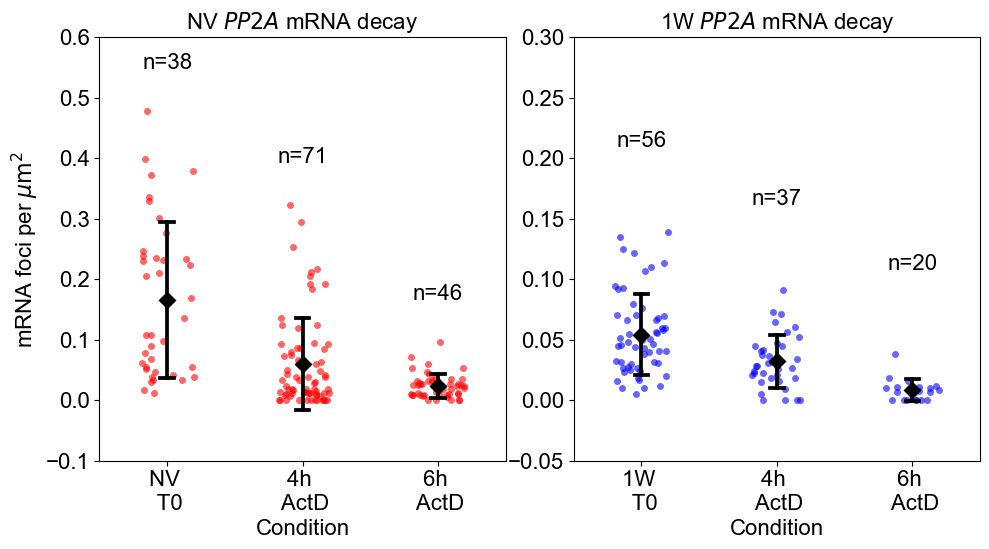

In [7]:
# Repeat the above plot for PP2A data
file_path = 'FLC_mRNA_ActD_Decay_Exp2_Dataset.xlsx'
df_pp2a = pd.read_excel(file_path, sheet_name='PP2A Summary', engine='openpyxl')
# Extract the first 3 columns to make the NV data table
NV_df_pp2a = df_pp2a.iloc[:, 0:3]
# Extract the last 3 columns to make the W2 data table
W2_df_pp2a = df_pp2a.iloc[:, 3:]


# Plot the data
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
sns.stripplot(data=NV_df_pp2a, color='red', jitter=0.2, size=5, alpha=0.6, zorder=1)  # Lower zorder
sns.pointplot(data=NV_df_pp2a, color='black', errorbar='sd', capsize=0.1, markers='D', linestyle='none', zorder=2)  # Higher zorder
# Add annotations for the number of data points
for i, col in enumerate(NV_df_pp2a.columns):
    count = NV_df_pp2a[col].dropna().shape[0]  # Count non-NaN values
    plt.text(i, NV_df_pp2a[col].max() + 0.07, f'n={count}', ha='center', fontsize=16, color='black')
#Set xtick labels
plt.xticks([0, 1, 2], ['NV \n T0', '4h \n ActD', '6h \n ActD'])
plt.ylabel(r'mRNA foci per $\mu \mathrm{m}^2$', fontsize=16)
plt.xlabel('Condition', fontsize=16)
plt.title(r'NV $\mathit{PP2A}$ mRNA decay', fontsize=16)
#Set y-axis limits
plt.ylim(-0.1, 0.6)
#Set xtick label size
plt.xticks(fontsize=16)
#Set ytick label size
plt.yticks(fontsize=16)
#Set yticks
# plt.yticks(np.arange(0, 1.6, 0.5))    
plt.subplot(1, 2, 2)
sns.stripplot(data=W2_df_pp2a, color='blue', jitter=0.2, size=5, alpha=0.6, zorder=1)  # Lower zorder
sns.pointplot(data=W2_df_pp2a, color='black', errorbar='sd', capsize=0.1, markers='D', linestyle='none', zorder=2)  # Higher zorder
# Add annotations for the number of data points
for i, col in enumerate(W2_df_pp2a.columns):
    count = W2_df_pp2a[col].dropna().shape[0]  # Count non-NaN values
    plt.text(i, W2_df_pp2a[col].max() + 0.07, f'n={count}', ha='center', fontsize=16, color='black')
#Set xtick labels
plt.xticks([0, 1, 2], ['1W \n T0', '4h \n ActD', '6h \n ActD'])
# plt.ylabel(r'mRNA foci per $\mu \mathrm{m}^2$', fontsize=16)  
plt.xlabel('Condition', fontsize=16)
plt.title(r'1W $\mathit{PP2A}$ mRNA decay', fontsize=16)
#Set xtick label size
plt.xticks(fontsize=16)
#Set ytick label size
plt.yticks(fontsize=16)
#Set yticks
# plt.yticks(np.arange(0, 1.6, 0.5))
plt.tight_layout()
#Set y-axis limits
plt.ylim(-0.05, 0.3) # Set the y-axis limits to be the same for both plots
plt.savefig('PP2A_smFISH_decayplot_combined_Exp2_v2.pdf')

plt.show()



## Estimate Expt2 PP2A decay rates by nested sampling

### First for NV data

it= 52623 logz=193.1792723833niter: 52624
ncall: 252186
nsamples: 62624
logz: 193.596 +/-  0.018
h:  3.285
a =  0.53 +/-  0.27
k =  0.51 +/-  0.10
Half-life =  1.37 +/-  0.27


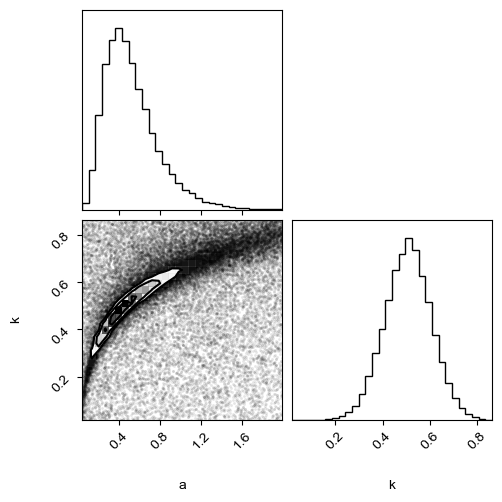

In [8]:
# Fit an exponential decay model to the PP2A NV data using nestle for Bayesian inference
# Extract the non-NaN values for the 0h time point into an array
NV_T0 = NV_df_pp2a.iloc[:, 0].dropna().values
# Extract the non-NaN values for the 4h time point into an array
NV_4h = NV_df_pp2a.iloc[:, 1].dropna().values
# Extract the non-NaN values for the 6h time point into an array
NV_6h = NV_df_pp2a.iloc[:, 2].dropna().values   
# Combine the arrays into a single vertical array
NV_data = np.concatenate((NV_4h, NV_6h))
# Create an array of time points corresponding to the data
time_points = np.concatenate((np.full(NV_4h.shape, 4), np.full(NV_6h.shape, 6)))   
# Define x, y, and yerr for NV data
x = time_points
y = NV_data
# Estimate yerr as the standard deviation at each time point
yerr = np.zeros_like(y)
for t in np.unique(x):  
    mask = x == t
    yerr[mask] = np.std(y[mask])
# Avoid division by zero
yerr[yerr == 0] = np.mean(yerr[yerr > 0])
# Define the model function
def model1(theta, x):
    a, k = theta
    return a * np.exp(-k * x)
# Define the log-likelihood function
def log_likelihood(theta):
    a, k = theta
    model_y = model1(theta, x)
    return -0.5 * np.sum(((y - model_y) / yerr) ** 2 + np.log(2 * np.pi * yerr ** 2))

# Defines a flat prior in 0 < m < 1, 0 < a < 2:
def prior_transform(theta):
    return np.array([2., 1.]) * theta
ndim = 2  # number of parameters
res = nestle.sample(log_likelihood, prior_transform, ndim, method='single',
                    npoints=10000, callback=nestle.print_progress)
print(res.summary())
# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)
print("a = {0:5.2f} +/- {1:5.2f}".format(p[0], np.sqrt(cov[0, 0])))
print("k = {0:5.2f} +/- {1:5.2f}".format(p[1], np.sqrt(cov[1, 1])))
# Compute the half-life and its error
decay_constant = p[1]
half_life = np.log(2) / decay_constant
half_life_error = np.log(2) / (decay_constant**2) * np.sqrt(cov[1, 1])
print("Half-life = {0:5.2f} +/- {1:5.2f}".format(half_life, half_life_error))
#%% Plot the corner plot for the parameters
fig = corner.corner(res.samples, weights=res.weights, labels=['a', 'k'],
                    range=[0.9999, 0.99999], bins=30)
plt.show()

### Next for 1W cold data

it= 51288 logz=151.3062790360niter: 51289
ncall: 208855
nsamples: 61289
logz: 151.715 +/-  0.018
h:  3.244
a =  0.86 +/-  0.44
k =  0.78 +/-  0.13
Half-life =  0.88 +/-  0.15


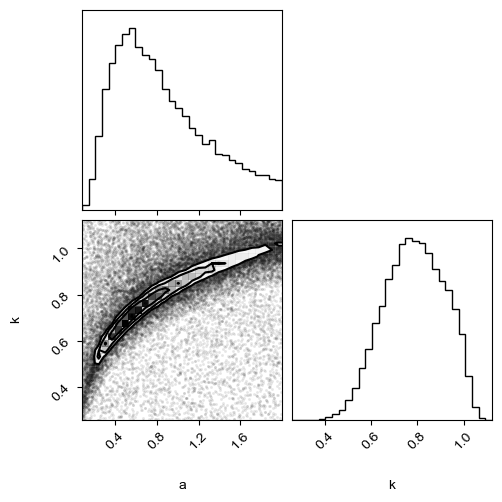

In [13]:
# Fit an exponential decay model to the PP2A W2 data using nestle for Bayesian inference
# Extract the non-NaN values for the 0h time point into an array
W2_T0 = W2_df_pp2a.iloc[:, 0].dropna().values
# Extract the non-NaN values for the 4h time point into an array
W2_4h = W2_df_pp2a.iloc[:, 1].dropna().values
# Extract the non-NaN values for the 6h time point into an array
W2_6h = W2_df_pp2a.iloc[:, 2].dropna().values    
# Combine the arrays into a single vertical array
W2_data = np.concatenate((W2_4h, W2_6h))
# Create an array of time points corresponding to the data
time_points = np.concatenate((np.full(W2_4h.shape, 4), np.full(W2_6h.shape, 6)))   
# Define x, y, and yerr for W2 data
x = time_points
y = W2_data
# Estimate yerr as the standard deviation at each time point
yerr = np.zeros_like(y)
for t in np.unique(x):  
    mask = x == t
    yerr[mask] = np.std(y[mask])
# Avoid division by zero
yerr[yerr == 0] = np.mean(yerr[yerr > 0])
# Define the model function
def model1(theta, x):
    a, k = theta
    return a * np.exp(-k * x)
# Define the log-likelihood function
def log_likelihood(theta):
    a, k = theta
    model_y = model1(theta, x)
    return -0.5 * np.sum(((y - model_y) / yerr) ** 2 + np.log(2 * np.pi * yerr ** 2))
# Defines a flat prior in 0 < m < 1, 0 < a < 2:
def prior_transform(theta):
    return np.array([2., 2.]) * theta
ndim = 2  # number of parameters
res = nestle.sample(log_likelihood, prior_transform, ndim, method='single',
                    npoints=10000, callback=nestle.print_progress)
print(res.summary())
# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)
print("a = {0:5.2f} +/- {1:5.2f}".format(p[0], np.sqrt(cov[0, 0])))
print("k = {0:5.2f} +/- {1:5.2f}".format(p[1], np.sqrt(cov[1, 1])))
# Compute the half-life and its error
decay_constant = p[1]
half_life = np.log(2) / decay_constant
half_life_error = np.log(2) / (decay_constant**2) * np.sqrt(cov[1, 1])
print("Half-life = {0:5.2f} +/- {1:5.2f}".format(half_life, half_life_error))
#%% Plot the corner plot for the parameters
fig = corner.corner(res.samples, weights=res.weights, labels=['a', 'k'],
                    range=[0.9999, 0.99999], bins=30)
plt.show()

### Alternatively compute just the best fit decay parameters

In [ ]:
# Alternatively calculate PP2A decay rates for Expt 2 data, using only the 4h and 6h data (as in Ietswaart et al., 2016)
# For NV
pp2a_NV_4h = NV_df_pp2a.iloc[:, 1].dropna().values
pp2a_NV_6h = NV_df_pp2a.iloc[:, 2].dropna().values
# Calculate means
pp2a_NV_4h_mean = np.mean(pp2a_NV_4h)
pp2a_NV_6h_mean = np.mean(pp2a_NV_6h)
# Calculate standard error of the mean
pp2a_NV_4h_sem = np.std(pp2a_NV_4h, ddof=1) / np.sqrt(len(pp2a_NV_4h))
pp2a_NV_6h_sem = np.std(pp2a_NV_6h, ddof=1) / np.sqrt(len(pp2a_NV_6h))
# Calculate decay constant and half-life using the means
k_NV = -np.log(pp2a_NV_6h_mean / pp2a_NV_4h_mean) / (6 - 4)
half_life_NV = np.log(2) / k_NV
# Propagate error for decay constant
k_NV_error = np.sqrt((pp2a_NV_4h_sem / pp2a_NV_4h_mean)**2 + (pp2a_NV_6h_sem / pp2a_NV_6h_mean)**2) * k_NV
half_life_NV_error = (np.log(2) / (k_NV**2)) * k_NV_error
print("Exponential decay fit results for NV (Exp 2, PP2A):")
print(f"Decay constant (k): {k_NV:.4f} ± {k_NV_error:.4f}")
print(f"Half-life: {half_life_NV:.4f} ± {half_life_NV_error:.4f}")

# For W2
pp2a_W2_4h = W2_df_pp2a.iloc[:, 1].dropna().values
pp2a_W2_6h = W2_df_pp2a.iloc[:, 2].dropna().values
# Calculate means
pp2a_W2_4h_mean = np.mean(pp2a_W2_4h)
pp2a_W2_6h_mean = np.mean(pp2a_W2_6h)
# Calculate standard error of the mean
pp2a_W2_4h_sem = np.std(pp2a_W2_4h, ddof=1) / np.sqrt(len(pp2a_W2_4h))
pp2a_W2_6h_sem = np.std(pp2a_W2_6h, ddof=1) / np.sqrt(len(pp2a_W2_6h))
# Calculate decay constant and half-life using the means
k_W2 = -np.log(pp2a_W2_6h_mean / pp2a_W2_4h_mean) / (6 - 4)
half_life_W2 = np.log(2) / k_W2
# Propagate error for decay constant
k_W2_error = np.sqrt((pp2a_W2_4h_sem / pp2a_W2_4h_mean)**2 + (pp2a_W2_6h_sem / pp2a_W2_6h_mean)**2) * k_W2
half_life_W2_error = (np.log(2) / (k_W2**2)) * k_W2_error
print("Exponential decay fit results for W2 (Exp 2, PP2A):")
print(f"Decay constant (k): {k_W2:.4f} ± {k_W2_error:.4f}")
print(f"Half-life: {half_life_W2:.4f} ± {half_life_W2_error:.4f}")


Exponential decay fit results for NV (Exp 2, PP2A):
Decay constant (k): 0.4605 ± 0.0897
Half-life: 1.5053 ± 0.2933
Exponential decay fit results for W2 (Exp 2, PP2A):
Decay constant (k): 0.6886 ± 0.1873
Half-life: 1.0067 ± 0.2739


## Perform ANCOVA for Expt 2 PP2A data, to compare NV and 1W decay rates

In [9]:
# Perform ANCOVA for PP2A data
# Extract the non-NaN values for the 0h time point into an array
NV_T0 = NV_df_pp2a.iloc[:, 0].dropna().values
# Extract the non-NaN values for the 4h time point into an array
NV_4h = NV_df_pp2a.iloc[:, 1].dropna().values
# Extract the non-NaN values for the 6h time point into an array
NV_6h = NV_df_pp2a.iloc[:, 2].dropna().values
# Combine the arrays into a single vertical array
NV_data = np.concatenate((NV_4h, NV_6h))
# Add 1e-6 to avoid log(0)
NV_data = NV_data + 1e-6
# Create an array of time points corresponding to the data
time_points = np.concatenate((np.full(NV_4h.shape, 4), np.full(NV_6h.shape, 6)))
ones_array = np.ones(NV_data.shape)
# Make a linear fit to the log of the data
log_data = np.log(NV_data)
X = np.column_stack((ones_array,time_points))
NV_x = time_points
NV_y = log_data
# Create an array with the label 'NV' repeated for the length of the data
NV_group = np.full(NV_data.shape, 'NV')
# Combine the data into a DataFrame
NV_df_combined = pd.DataFrame({'time': NV_x, 'log_data': NV_y, 'group': NV_group})

# Repeat for W2
# Extract the non-NaN values for the 0h time point into an array
W2_T0 = W2_df_pp2a.iloc[:, 0].dropna().values
# Extract the non-NaN values for the 4h time point into an array
W2_4h = W2_df_pp2a.iloc[:, 1].dropna().values
# Extract the non-NaN values for the 6h time point into an array
W2_6h = W2_df_pp2a.iloc[:, 2].dropna().values
# Combine the arrays into a single vertical array
W2_data = np.concatenate((W2_T0, W2_4h, W2_6h))
# Add 1e-6 to avoid log(0)
W2_data = W2_data + 1e-6
# Create an array of time points corresponding to the data
time_points = np.concatenate((np.full(W2_T0.shape, 0), np.full(W2_4h.shape, 4), np.full(W2_6h.shape, 6)))
ones_array = np.ones(W2_data.shape)
# Make a linear fit to the log of the data
log_data = np.log(W2_data)
X = np.column_stack((ones_array,time_points))
W2_x = time_points
W2_y = log_data
# Create an array with the label 'W2' repeated for the length of the data
W2_group = np.full(W2_data.shape, 'W2')
# Combine the data into a DataFrame
W2_df_combined = pd.DataFrame({'time': W2_x, 'log_data': W2_y, 'group': W2_group})  
# Statistical comparison of NV and 2W fits
combined_df = pd.concat([NV_df_combined, W2_df_combined], ignore_index=True)
model = smf.ols('log_data ~ time * group', data=combined_df).fit()
# Print the summary of the model with more decimal places
print(model.summary2(float_format="%.5f"))

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.089    
Dependent Variable: log_data         AIC:                1211.8090
Date:               2025-09-15 14:26 BIC:                1225.5613
No. Observations:   230              Log-Likelihood:     -601.90  
Df Model:           3                F-statistic:        8.485    
Df Residuals:       226              Prob (F-statistic): 2.30e-05 
R-squared:          0.101            Scale:              11.174   
------------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept          -5.0930   1.5454 -3.2957 0.0011 -8.1382 -2.0479
group[T.W2]         2.1496   1.6062  1.3383 0.1821 -1.0155  5.3147
time                0.0242   0.3163  0.0764 0.9392 -0.5992  0.6475
time:group[T.W2]   -0.6530   0.3415 -1.9124 0.0571 -1.3259  0.0199
-------------

## For Expt 1 data, compare starting levels (without ActD treatment) at NV and 2W

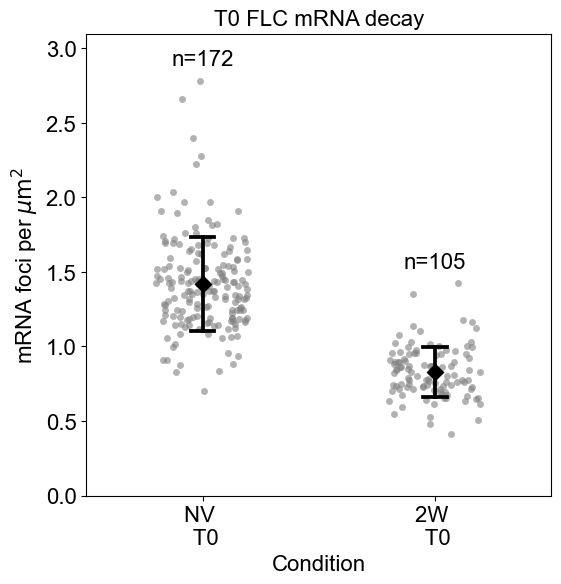

In [5]:
# Extract the first T0 columns to make the T0 data table
T0_df = df.iloc[:, [0,5]]
# Plot the T0 data
plt.figure(figsize=(6, 6))
sns.stripplot(data=T0_df, color='gray', jitter=0.2, size=5, alpha=0.6,zorder=1)  # Lower zorde
sns.pointplot(data=T0_df, color='black', errorbar='sd', capsize=0.1, markers='D',linestyle='none', zorder=2)  # Higher zorder
# Add annotations for the number of data points
for i, col in enumerate(T0_df.columns):
    count = T0_df[col].dropna().shape[0]  # Count non-NaN values
    plt.text(i, T0_df[col].max() + 0.1, f'n={count}', ha='center', fontsize=16, color='black')
#Set xtick labels
plt.xticks([0, 1], ['NV \n T0', '2W \n T0'])
plt.ylabel(r'mRNA foci per $\mu \mathrm{m}^2$', fontsize=16)
plt.xlabel('Condition', fontsize=16)
plt.title('T0 FLC mRNA decay', fontsize=16)
#Set xtick label size
plt.xticks(fontsize=16)
#Set ytick label size
plt.yticks(fontsize=16)
plt.ylim(0, 3.1)

# Save figure
plt.savefig('FLC_smFISH_T0_plot_v2.pdf',bbox_inches='tight')
plt.show()


# Fitting an exponential decay to the Expt 1 FLC data using nested sampling
## Two types of models are fit:
## Model 1: Exponential decay with a non-zero asymptote
## Model 2: Exponential decay with a zero asymptote

### First for the NV data

In [27]:
# Fit an exponential decay model with a non-zero asymptote to the FLC NV and 2W data (Expt 1)
# Extract the non-NaN values for the 2h time point into an array
NV_2h = NV_df.iloc[:, 2].dropna().values
# Extract the non-NaN values for the 4h time point into an array
NV_4h = NV_df.iloc[:, 3].dropna().values
# Extract the non-NaN values for the 6h time point into an array
NV_6h = NV_df.iloc[:, 4].dropna().values
# Combine the arrays into a single vertical array
NV_data = np.concatenate((NV_2h, NV_4h, NV_6h))
# Create an array of time points corresponding to the data
time_points = np.concatenate((np.full(NV_2h.shape, 2), np.full(NV_4h.shape, 4), np.full(NV_6h.shape, 6)))

def model1(theta, x):
    a, b, k = theta
    return a + np.exp(-k * x) * b

def model2(theta, x):
    a, k = theta
    return a * np.exp(-k * x)



# Define x, y, and yerr for NV data
x = time_points
y = NV_data
# Estimate yerr as the standard deviation at each time point
yerr = np.zeros_like(y)
for t in np.unique(x):  
    mask = x == t
    yerr[mask] = np.std(y[mask])
# Avoid division by zero
yerr[yerr == 0] = np.mean(yerr[yerr > 0])





### Run nested sampling for Model 1 (non-zero asymptote)

In [ ]:
# Run nested sampling for model1 (non-zero asymptote)
def model(theta, x):
    return model1(theta, x)

# The likelihood function:
def loglike(theta):
    return -0.5*(np.sum((y-model(theta, x))**2/yerr**2))


# Defines a flat prior in 0 < a < 0.5, 0 < b < 2, 0 < k < 1:
def prior_transform(theta):
    return np.array([0.5, 2., 1.]) * theta

ndim = 3  # number of parameters
res = nestle.sample(loglike, prior_transform, ndim, method='single',
                    npoints=10000, callback=nestle.print_progress)
print(res.summary())

# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)

print("a = {0:5.2f} +/- {1:5.2f}".format(p[0], np.sqrt(cov[0, 0])))
print("b = {0:5.2f} +/- {1:5.2f}".format(p[1], np.sqrt(cov[1, 1])))
print("k = {0:5.2f} +/- {1:5.2f}".format(p[2], np.sqrt(cov[2, 2])))

# Compute the half-life and its error
decay_constant = p[2]
half_life = np.log(2) / decay_constant
half_life_error = np.log(2) / (decay_constant**2) * np.sqrt(cov[2, 2])

print("Half-life = {0:5.2f} +/- {1:5.2f}".format(half_life, half_life_error))


it= 99268 logz=-206.04788942niter: 99269
ncall: 412729
nsamples: 109269
logz: -205.739 +/-  0.027
h:  7.308
a =  0.09 +/-  0.07
b =  1.15 +/-  0.05
k =  0.20 +/-  0.03
Half-life =  3.43 +/-  0.52


### Plot posterior distribution for Model 1 (non-zero asymptote)

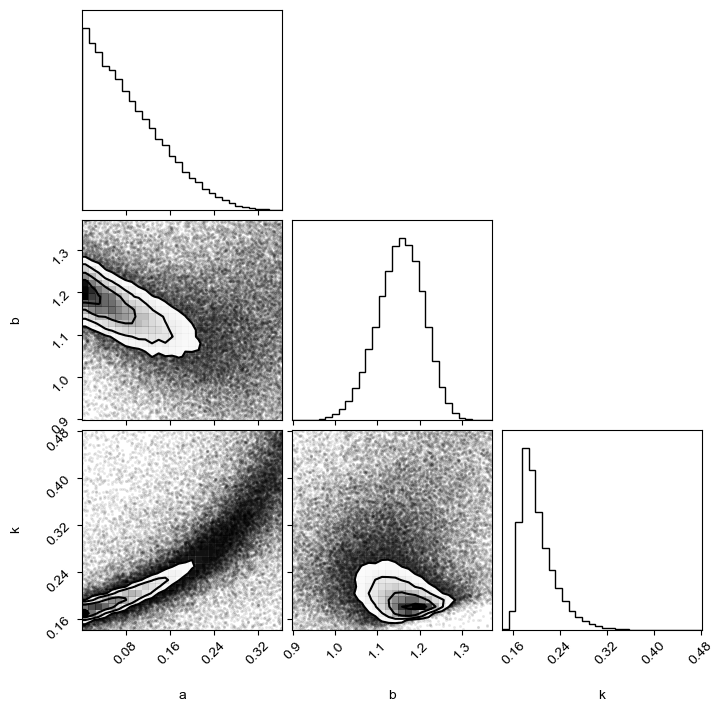

In [ ]:
#%% Plot the corner plot for the parameters
fig = corner.corner(res.samples, weights=res.weights, labels=['a', 'b', 'k'],
                    range=[0.9999, 0.99999, 0.99999], bins=30)

### Run nested sampling for Model 2 (zero asymptote) and plot the posterior distribution

it= 86581 logz=-204.77338565niter: 86582
ncall: 152064
nsamples: 96582
logz: -204.348 +/-  0.026
h:  6.799
a =  1.21 +/-  0.04
k =  0.17 +/-  0.01
Half-life =  4.06 +/-  0.19


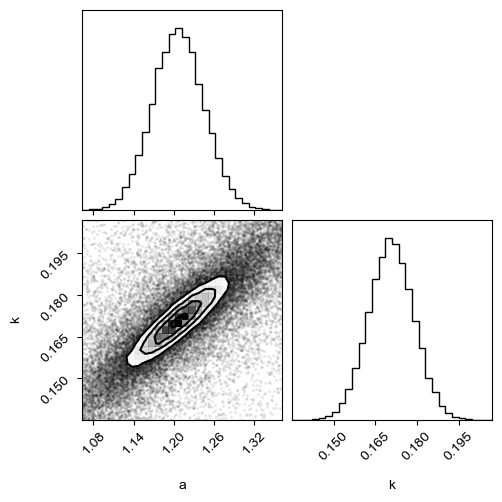

In [ ]:
# Run nested sampling for model2 (zero asymptote)
def model(theta, x): 
    return model2(theta, x)
# The likelihood function:
def loglike(theta):
    return -0.5*(np.sum((y-model(theta, x))**2/yerr**2))
# Defines a flat prior in 0 < a < 2, 0 < k < 1:
def prior_transform(theta):
    return np.array([2., 1.]) * theta
ndim = 2  # number of parameters
res = nestle.sample(loglike, prior_transform, ndim, method='single',
                    npoints=10000, callback=nestle.print_progress)
print(res.summary())
# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)

print("a = {0:5.2f} +/- {1:5.2f}".format(p[0], np.sqrt(cov[0, 0])))
print("k = {0:5.2f} +/- {1:5.2f}".format(p[1], np.sqrt(cov[1, 1])))
# Compute the half-life and its error
decay_constant = p[1]
half_life = np.log(2) / decay_constant
half_life_error = np.log(2) / (decay_constant**2) * np.sqrt(cov[1, 1])
print("Half-life = {0:5.2f} +/- {1:5.2f}".format(half_life, half_life_error))
#%% Plot the corner plot for the parameters
fig = corner.corner(res.samples, weights=res.weights, labels=['a', 'k'],
                    range=[0.9999, 0.99999], bins=30)
# Save figure
plt.savefig('FLC_smFISH_NV_decay_cornerplot_v2.pdf',bbox_inches='tight')
plt.show()


### Plot the model fits for the NV data

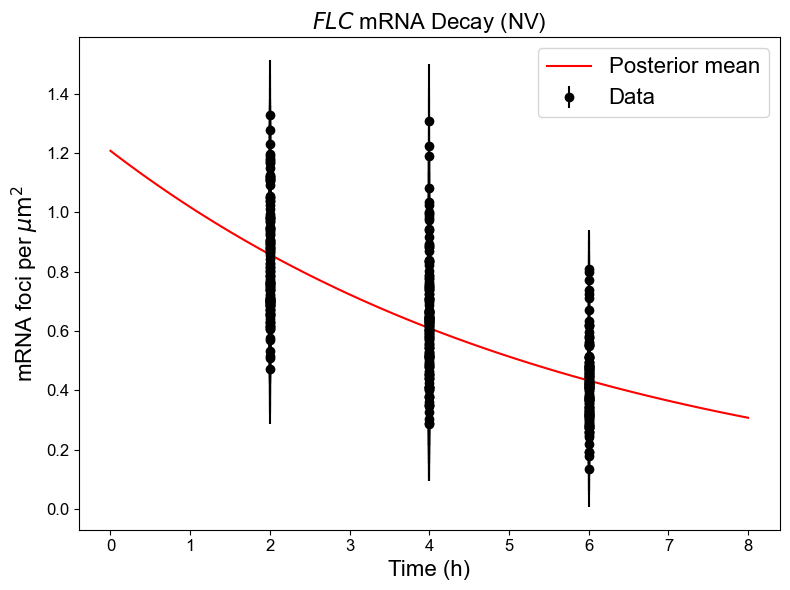

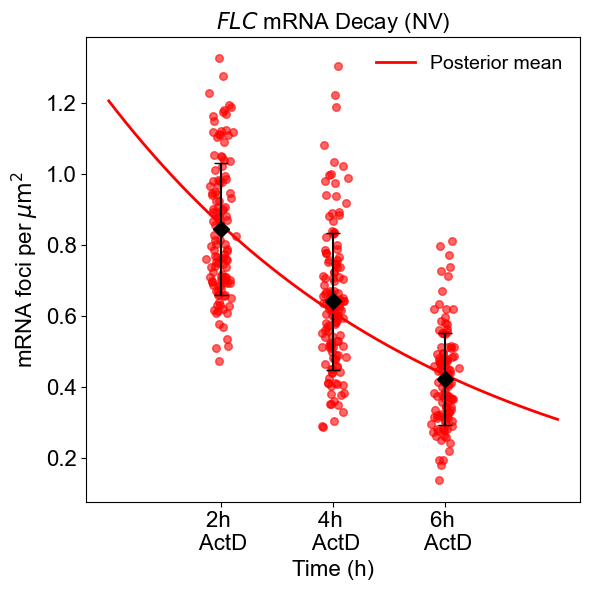

In [26]:
# Plot the model fit
plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr=yerr, fmt='o', color='black', label='Data')
x_fit = np.linspace(0, 8, 100)
y_fit = model(p, x_fit)
plt.plot(x_fit, y_fit, color='red', label='Posterior mean')
plt.xlabel('Time (h)', fontsize=16)
plt.ylabel(r'mRNA foci per $\mu \mathrm{m}^2$', fontsize=16)
# Set xtick label size
plt.xticks(fontsize=12)
# Set ytick label size
plt.yticks(fontsize=12)
plt.title('$FLC$ mRNA Decay (NV)', fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('FLC_mRNA_decay_model_fit_NV.pdf')
plt.show()

# Plot the y data as before but include the model fit
plt.figure(figsize=(6, 6))
# Add jitter to x values for better visualization
x_jittered = x + np.random.normal(0, 0.1, size=x.shape)
plt.scatter(x_jittered, y, color='red', alpha=0.6, s=30)
plt.errorbar(np.unique(x), [np.mean(y[x == t]) for t in np.unique(x)], 
             yerr=[np.std(y[x == t]) for t in np.unique(x)], 
             fmt='D', color='black', capsize=5, markersize=8)
# Add the model fit
x_fit = np.linspace(0, 8, 100)
y_fit = model2(p, x_fit)
plt.plot(x_fit, y_fit, color='red', linewidth=2, label='Posterior mean')
plt.xlabel('Time (h)', fontsize=16)
plt.ylabel(r'mRNA foci per $\mu \mathrm{m}^2$', fontsize=16)
plt.title('$FLC$ mRNA Decay (NV)', fontsize=16)
plt.xticks([2, 4, 6], ['2h \n ActD', '4h \n ActD', '6h \n ActD'], fontsize=16)
plt.yticks(fontsize=16)
# Show legend without box
plt.legend(fontsize=14, frameon=False)
plt.tight_layout()
# Save figure
plt.savefig('FLC_smFISH_NV_decayplot_withfit_v2.pdf',bbox_inches='tight')
plt.show()

### Now for the 2W cold data

In [28]:
# Repeat the fitting for the W2 data
# Extract the non-NaN values for the 2h time point into an array
W2_2h = W2_df.iloc[:, 2].dropna().values
# Extract the non-NaN values for the 4h time point into an array
W2_4h = W2_df.iloc[:, 3].dropna().values
# Extract the non-NaN values for the 6h time point into an array
W2_6h = W2_df.iloc[:, 4].dropna().values
# Combine the arrays into a single vertical array
W2_data = np.concatenate((W2_2h, W2_4h, W2_6h))
# Create an array of time points corresponding to the data
time_points = np.concatenate((np.full(W2_2h.shape, 2), np.full(W2_4h.shape, 4), np.full(W2_6h.shape, 6)))
# Define x, y, and yerr for W2 data
x = time_points
y = W2_data
# Estimate yerr as the standard deviation at each time point
yerr = np.zeros_like(y)
for t in np.unique(x):
    mask = x == t
    yerr[mask] = np.std(y[mask])
# Avoid division by zero
yerr[yerr == 0] = np.mean(yerr[yerr > 0])   

def model1(theta, x):
    a, b, k = theta
    return a + np.exp(-k * x) * b

def model2(theta, x):
    a, k = theta
    return a * np.exp(-k * x)

   



### Run nested sampling for Model 1 (non-zero asymptote) and plot the posterior distribution

it=102908 logz=-191.09673033niter: 102909
ncall: 639448
nsamples: 112909
logz: -190.784 +/-  0.028
h:  7.698
a =  0.08 +/-  0.06
b =  0.66 +/-  0.05
k =  0.18 +/-  0.04
Half-life =  3.86 +/-  0.87


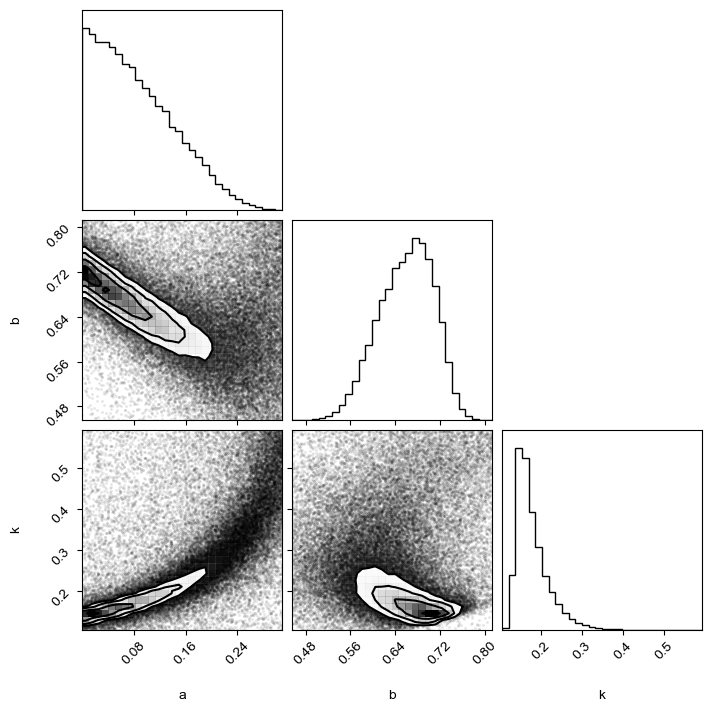

In [29]:
# Run nested sampling for model1 (non-zero asymptote)
def model(theta, x):
    return model1(theta, x)
# The likelihood function:
def loglike(theta):
    return -0.5*(np.sum((y-model(theta, x))**2/yerr**2))
# Defines a flat prior in 0 < m < 1, 0 < b < 100:
def prior_transform(theta):
    return np.array([0.5, 2., 1.]) * theta
ndim = 3  # number of parameters
res = nestle.sample(loglike, prior_transform, ndim, method='single',
                    npoints=10000, callback=nestle.print_progress)
print(res.summary())

# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)

print("a = {0:5.2f} +/- {1:5.2f}".format(p[0], np.sqrt(cov[0, 0])))
print("b = {0:5.2f} +/- {1:5.2f}".format(p[1], np.sqrt(cov[1, 1])))
print("k = {0:5.2f} +/- {1:5.2f}".format(p[2], np.sqrt(cov[2, 2])))

# Compute the half-life and its error
decay_constant = p[2]
half_life = np.log(2) / decay_constant
half_life_error = np.log(2) / (decay_constant**2) * np.sqrt(cov[2, 2])
print("Half-life = {0:5.2f} +/- {1:5.2f}".format(half_life, half_life_error))

# Plot the corner plot for the W2 parameters
fig = corner.corner(res.samples, weights=res.weights, labels=['a', 'b', 'k'],
                    range=[0.9999, 0.99999, 0.99999], bins=30)

### Run nested sampling for Model 2 (zero asymptote) and plot the posterior distribution

it= 91224 logz=-189.92115138niter: 91225
ncall: 158052
nsamples: 101225
logz: -189.496 +/-  0.027
h:  7.266
a =  0.72 +/-  0.02
k =  0.14 +/-  0.01
Half-life =  4.99 +/-  0.32


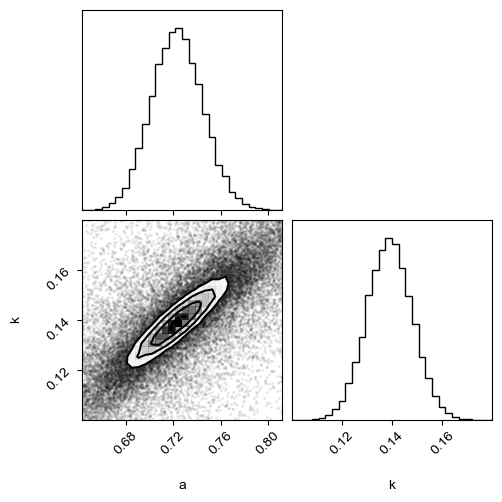

In [30]:
# Run nested sampling for model2 (zero asymptote)

def model(theta, x):
    return model2(theta, x)
# The likelihood function:
def loglike(theta):
    return -0.5*(np.sum((y-model(theta, x))**2/yerr**2))
# Defines a flat prior in 0 < m < 1, 0 < a < 2:
def prior_transform(theta):
    return np.array([2., 1.]) * theta
ndim = 2  # number of parameters
res = nestle.sample(loglike, prior_transform, ndim, method='single',
                    npoints=10000, callback=nestle.print_progress)
print(res.summary())
# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)  
print("a = {0:5.2f} +/- {1:5.2f}".format(p[0], np.sqrt(cov[0, 0])))
print("k = {0:5.2f} +/- {1:5.2f}".format(p[1], np.sqrt(cov[1, 1])))
# Compute the half-life and its error
decay_constant = p[1]
half_life = np.log(2) / decay_constant
half_life_error = np.log(2) / (decay_constant**2) * np.sqrt(cov[1, 1])
print("Half-life = {0:5.2f} +/- {1:5.2f}".format(half_life, half_life_error))
# Plot the corner plot for the parameters
fig = corner.corner(res.samples, weights=res.weights, labels=['a', 'k'],
                    range=[0.9999, 0.99999], bins=30)
# Save figure
plt.savefig('FLC_smFISH_W2_decay_cornerplot_v2.pdf',bbox_inches='tight')
plt.show()

### Plot the model fits for the 2W data

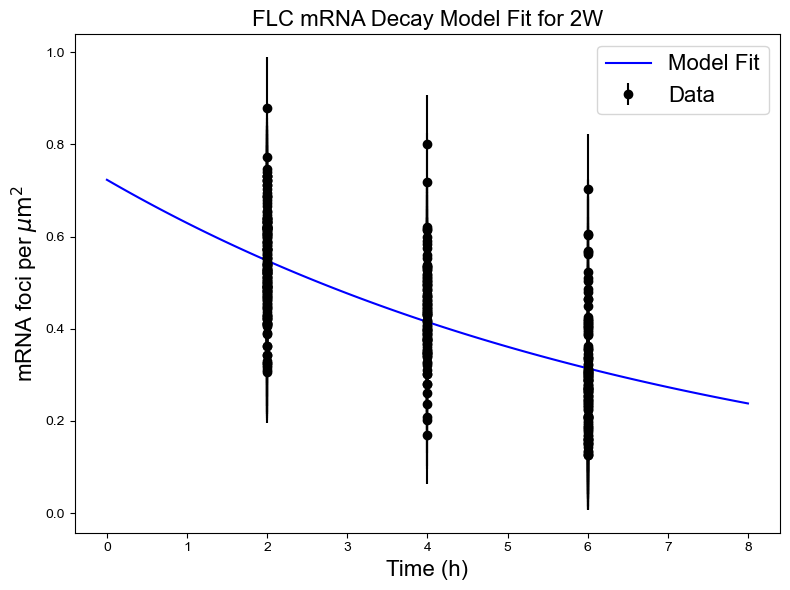

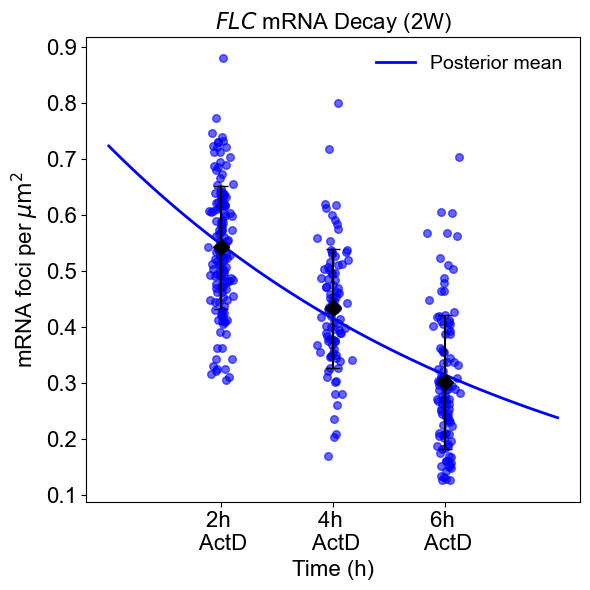

In [31]:
# Plot the model fit
plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr=yerr, fmt='o', color='black', label='Data')
x_fit = np.linspace(0, 8, 100)
y_fit = model(p, x_fit) 
plt.plot(x_fit, y_fit, color='blue', label='Model Fit')
plt.xlabel('Time (h)', fontsize=16)
plt.ylabel(r'mRNA foci per $\mu \mathrm{m}^2$', fontsize=16)
plt.title('FLC mRNA Decay Model Fit for 2W', fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('FLC_mRNA_decay_model_fit_2W.pdf')
plt.show()

# Plot the y data as before but include the model fit
plt.figure(figsize=(6, 6))
# Add jitter to x values for better visualization
x_jittered = x + np.random.normal(0, 0.1, size=x.shape)
plt.scatter(x_jittered, y, color='blue', alpha=0.6, s=30)
plt.errorbar(np.unique(x), [np.mean(y[x == t]) for t in np.unique(x)], 
             yerr=[np.std(y[x == t]) for t in np.unique(x)], 
             fmt='D', color='black', capsize=5, markersize=8)
# Add the model fit
x_fit = np.linspace(0, 8, 100)
y_fit = model2(p, x_fit)
plt.plot(x_fit, y_fit, color='blue', linewidth=2, label='Posterior mean')
plt.xlabel('Time (h)', fontsize=16)
plt.ylabel(r'mRNA foci per $\mu \mathrm{m}^2$', fontsize=16)
plt.title('$FLC$ mRNA Decay (2W)', fontsize=16)
plt.xticks([2, 4, 6], ['2h \n ActD', '4h \n ActD', '6h \n ActD'], fontsize=16)
plt.yticks(fontsize=16)
# Show legend without box
plt.legend(fontsize=14, frameon=False)
plt.tight_layout()
# Save figure
plt.savefig('FLC_smFISH_2W_decayplot_withfit_v2.pdf',bbox_inches='tight')
plt.show()

# For Expt 1 FLC data, analyse the difference between NV and 2W decay rates by comparing the Bayesian evidence for two models: 
# (Model 4) with same value of decay rate parameter in both conditions, 
# (Model 3) with different values of decay rate parameter in NV and 2W conditions 

### First import Expt 1 data and specify model 3

In [ ]:
# Perform nested sampling with zero-asymptote model for NV and 2W together, allowing different decay rates and intial values (Model 3)
file_path = 'FLC_mRNA_ActD_Decay_Exp1_Dataset.xlsx'
df = pd.read_excel(file_path, sheet_name='Final Summary', engine='openpyxl')

# Extract the first 5 columns to make the NV data table
NV_df = df.iloc[:, 0:5]

# Extract the last 5 columns to make the W2 data table
W2_df = df.iloc[:, 5:]

# Extract the non-NaN values for the 2h time point into an array
NV_2h = NV_df.iloc[:, 2].dropna().values
# Estimate the NV_2h standard deviation
NV_2h_std = np.std(NV_2h)
# Extract the non-NaN values for the 4h time point into an array
NV_4h = NV_df.iloc[:, 3].dropna().values
# Estimate the NV_4h standard deviation
NV_4h_std = np.std(NV_4h)
# Extract the non-NaN values for the 6h time point into an array
NV_6h = NV_df.iloc[:, 4].dropna().values
# Estimate the NV_6h standard deviation
NV_6h_std = np.std(NV_6h)
# Combine the arrays into a single vertical array
NV_data = np.concatenate((NV_2h, NV_4h, NV_6h))
# Put the corresponding standard deviations into a single vertical array
NV_std = np.concatenate((np.full(NV_2h.shape, NV_2h_std), np.full(NV_4h.shape, NV_4h_std), np.full(NV_6h.shape, NV_6h_std)))
# Create an array of time points corresponding to the data
nv_time_points = np.concatenate((np.full(NV_2h.shape, 2), np.full(NV_4h.shape, 4), np.full(NV_6h.shape, 6)))

# Repeat for W2
# Extract the non-NaN values for the 2h time point into an array
W2_2h = W2_df.iloc[:, 2].dropna().values
# Estimate the W2_2h standard deviation
W2_2h_std = np.std(W2_2h)
# Extract the non-NaN values for the 4h time point into an array
W2_4h = W2_df.iloc[:, 3].dropna().values
# Estimate the W2_4h standard deviation
W2_4h_std = np.std(W2_4h)
# Extract the non-NaN values for the 6h time point into an array
W2_6h = W2_df.iloc[:, 4].dropna().values
# Estimate the W2_6h standard deviation
W2_6h_std = np.std(W2_6h)
# Combine the arrays into a single vertical array
W2_data = np.concatenate((W2_2h, W2_4h, W2_6h))
# Put the corresponding standard deviations into a single vertical array
W2_std = np.concatenate((np.full(W2_2h.shape, W2_2h_std), np.full(W2_4h.shape, W2_4h_std), np.full(W2_6h.shape, W2_6h_std)))
# Create an array of time points corresponding to the data
w2_time_points = np.concatenate((np.full(W2_2h.shape, 2), np.full(W2_4h.shape, 4), np.full(W2_6h.shape, 6)))



def model3(theta, x):
    a_NV, k_NV, a_W2, k_W2 = theta
    
    model_y = a_NV * np.exp(-k_NV * x[:, 0]) * (x[:, 1] == 0) + a_W2 * np.exp(-k_W2 * x[:, 0]) * (x[:, 1] == 1)
   
    return model_y
# Combine NV and W2 data
x_NV = np.column_stack((nv_time_points, np.zeros_like(nv_time_points)))  # Group 0 for NV
x_W2 = np.column_stack((w2_time_points, np.ones_like(w2_time_points)))  # Group 1 for W2
x_combined = np.vstack((x_NV, x_W2))
y_combined = np.concatenate((NV_data, W2_data))
# Estimate yerr as the standard deviation at each time point
yerr_combined = np.concatenate((NV_std, W2_std))


# The likelihood function:
def loglike(theta):
    return -0.5*(np.sum((y_combined-model3(theta, x_combined))**2/yerr_combined**2))
# Defines a flat prior in 0 < m < 1, 0 < a < 2:
def prior_transform(theta):
    return np.array([2., 1., 2., 1.]) * theta
ndim = 4  # number of parameters


### Run nested sampling for model 3 with Expt 1 data

it=167212 logz=-394.07192962niter: 167213
ncall: 385468
nsamples: 177213
logz: -393.774 +/-  0.037
h: 13.986
a_NV =  1.21 +/-  0.04
k_NV =  0.17 +/-  0.01
a_W2 =  0.72 +/-  0.02
k_W2 =  0.14 +/-  0.01
NV Half-life =  4.06 +/-  0.19
W2 Half-life =  4.99 +/-  0.32


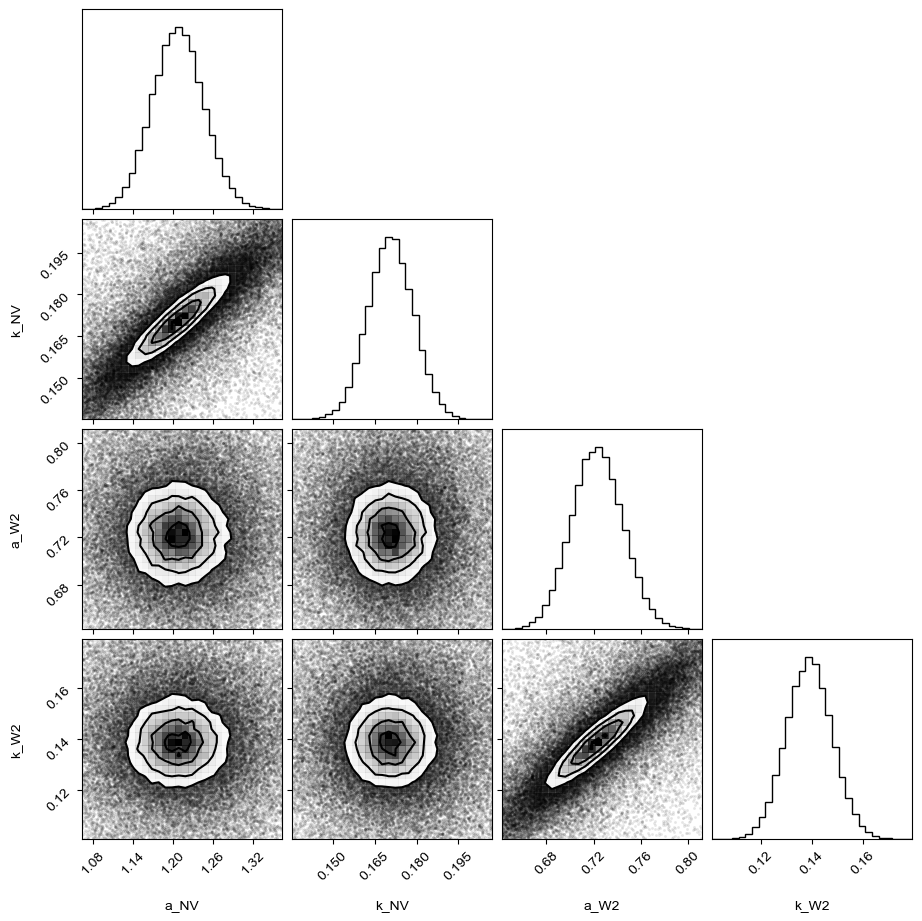

In [4]:
# Run nested sampling
res = nestle.sample(loglike, prior_transform, ndim, method='single',
                    npoints=10000, callback=nestle.print_progress)
print(res.summary())
# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)
print("a_NV = {0:5.2f} +/- {1:5.2f}".format(p[0], np.sqrt(cov[0, 0])))
print("k_NV = {0:5.2f} +/- {1:5.2f}".format(p[1], np.sqrt(cov[1, 1])))
print("a_W2 = {0:5.2f} +/- {1:5.2f}".format(p[2], np.sqrt(cov[2, 2])))
print("k_W2 = {0:5.2f} +/- {1:5.2f}".format(p[3], np.sqrt(cov[3, 3])))
# Compute the half-life and its error for both NV and 2W
decay_constant_NV = p[1]
half_life_NV = np.log(2) / decay_constant_NV
half_life_NV_error = np.log(2) / (decay_constant_NV**2) * np.sqrt(cov[1, 1])
print("NV Half-life = {0:5.2f} +/- {1:5.2f}".format(half_life_NV, half_life_NV_error))
decay_constant_W2 = p[3]
half_life_W2 = np.log(2) / decay_constant_W2
half_life_W2_error = np.log(2) / (decay_constant_W2**2) * np.sqrt(cov[3, 3])
print("W2 Half-life = {0:5.2f} +/- {1:5.2f}".format(half_life_W2, half_life_W2_error))
#%% Plot the corner plot for the parameters
fig = corner.corner(res.samples, weights=res.weights, labels=['a_NV', 'k_NV', 'a_W2', 'k_W2'],
                    range=[0.9999, 0.99999, 0.9999, 0.99999], bins=30)

### Now specify Model 4 and run nested sampling with Expt 1 data

it=133306 logz=-394.10544311niter: 133307
ncall: 253539
nsamples: 143307
logz: -393.749 +/-  0.033
h: 11.025
a_NV =  1.15 +/-  0.03
a_W2 =  0.76 +/-  0.02
k =  0.16 +/-  0.01
Half-life =  4.42 +/-  0.17


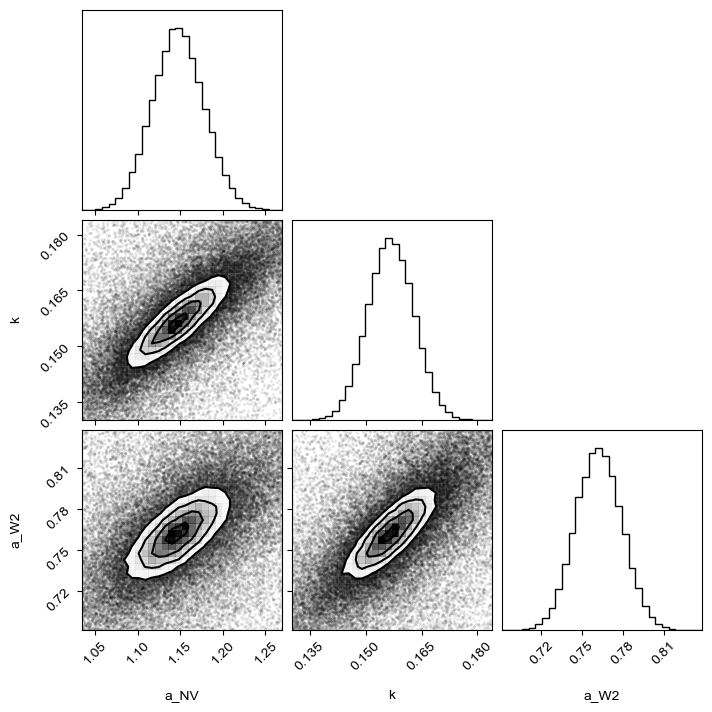

In [5]:
# Perform nested sampling with zero-asymptote model for NV and 2W together, keeping the same decay rate but different initial values
def model4(theta, x):
    a_NV, k, a_W2 = theta
    
    model_y = a_NV * np.exp(-k * x[:, 0]) * (x[:, 1] == 0) + a_W2 * np.exp(-k * x[:, 0]) * (x[:, 1] == 1)
   
    return model_y
# The likelihood function:
def loglike(theta):
    return -0.5*(np.sum((y_combined-model4(theta, x_combined))**2/yerr_combined**2))
# Defines a flat prior in 0 < m < 1, 0 < a < 2:
def prior_transform(theta):
    return np.array([2., 2., 1.]) * theta
ndim = 3  # number of parameters
# Run nested sampling
res = nestle.sample(loglike, prior_transform, ndim, method='single',
                    npoints=10000, callback=nestle.print_progress)
print(res.summary())

# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)
print("a_NV = {0:5.2f} +/- {1:5.2f}".format(p[0], np.sqrt(cov[0, 0])))
print("a_W2 = {0:5.2f} +/- {1:5.2f}".format(p[2], np.sqrt(cov[2, 2])))
print("k = {0:5.2f} +/- {1:5.2f}".format(p[1], np.sqrt(cov[1, 1])))
# Compute the half-life and its error
decay_constant = p[1]
half_life = np.log(2) / decay_constant
half_life_error = np.log(2) / (decay_constant**2) * np.sqrt(cov[1, 1])
print("Half-life = {0:5.2f} +/- {1:5.2f}".format(half_life, half_life_error))
#%% Plot the corner plot for the parameters
fig = corner.corner(res.samples, weights=res.weights, labels=['a_NV', 'k', 'a_W2'],
                    range=[0.9999, 0.99999, 0.99999], bins=30)
plt.show()

# The above analysis gives a Bayes factor (Evidence for Model 3/ Evidence for model 4) of $ B \approx e^{-0.16} \approx 0.86 $, which weakly favours Model 4 over Model 3, hence indicating no significant change in decay rate between NV and 2W for FLC

# For Expt 2 FLC data, analyse the difference between NV and 1W decay rates by comparing the Bayesian evidence for two models: 
# (Model 4) with same value of decay rate parameter in both conditions, 
# (Model 3) with different values of decay rate parameter in NV and 1W conditions 

### First import Expt 2 FLC data and specify model 3

In [6]:
# Perform nested sampling with zero-asymptote model for NV and 1W together, allowing different decay rates and intial values (Model 2)
# Import data (counts per unit area per cell) from Excel file for smFISH Expt 2
file_path = 'FLC_mRNA_ActD_Decay_Exp2_Dataset.xlsx'
df_flc = pd.read_excel(file_path, sheet_name='FLC Summary', engine='openpyxl')
# Extract the first 3 columns to make the NV data table
NV_df_flc = df_flc.iloc[:, 0:3]
# Extract the last 3 columns to make the W2 data table
W2_df_flc = df_flc.iloc[:, 3:]


# Extract the non-NaN values for the 4h time point into an array
NV_4h = NV_df_flc.iloc[:, 1].dropna().values
# Estimate the NV_4h standard deviation
NV_4h_std = np.std(NV_4h)
# Extract the non-NaN values for the 6h time point into an array
NV_6h = NV_df_flc.iloc[:, 2].dropna().values
# Estimate the NV_6h standard deviation
NV_6h_std = np.std(NV_6h)


# Combine only the 4h and 6h arrays into a single vertical array
NV_data = np.concatenate((NV_4h, NV_6h))
# Put the corresponding standard deviations into a single vertical array
NV_std = np.concatenate((np.full(NV_4h.shape, NV_4h_std), np.full(NV_6h.shape, NV_6h_std)))
# Create an array of time points corresponding to the data
nv_time_points = np.concatenate((np.full(NV_4h.shape, 4), np.full(NV_6h.shape, 6)))

# Repeat for W2

# Extract the non-NaN values for the 4h time point into an array
W2_4h = W2_df_flc.iloc[:, 1].dropna().values
# Estimate the W2_4h standard deviation
W2_4h_std = np.std(W2_4h)
# Extract the non-NaN values for the 6h time point into an array
W2_6h = W2_df_flc.iloc[:, 2].dropna().values
# Estimate the W2_6h standard deviation
W2_6h_std = np.std(W2_6h)
# Combine only the 4h and 6h arrays into a single vertical array
W2_data = np.concatenate((W2_4h, W2_6h))
# Put the corresponding standard deviations into a single vertical array
W2_std = np.concatenate((np.full(W2_4h.shape, W2_4h_std), np.full(W2_6h.shape, W2_6h_std)))
# Create an array of time points corresponding to the data
w2_time_points = np.concatenate((np.full(W2_4h.shape, 4), np.full(W2_6h.shape, 6)))





### Run nested sampling for Model 3 with Expt 2 FLC data

it=119558 logz=-98.537327862niter: 119559
ncall: 1377661
nsamples: 129559
logz: -98.242 +/-  0.030
h:  9.149
a_NV =  0.78 +/-  0.13
k_NV =  0.21 +/-  0.04
a_W2 =  0.54 +/-  0.16
k_W2 =  0.26 +/-  0.06
NV Half-life =  3.35 +/-  0.59
W2 Half-life =  2.66 +/-  0.64


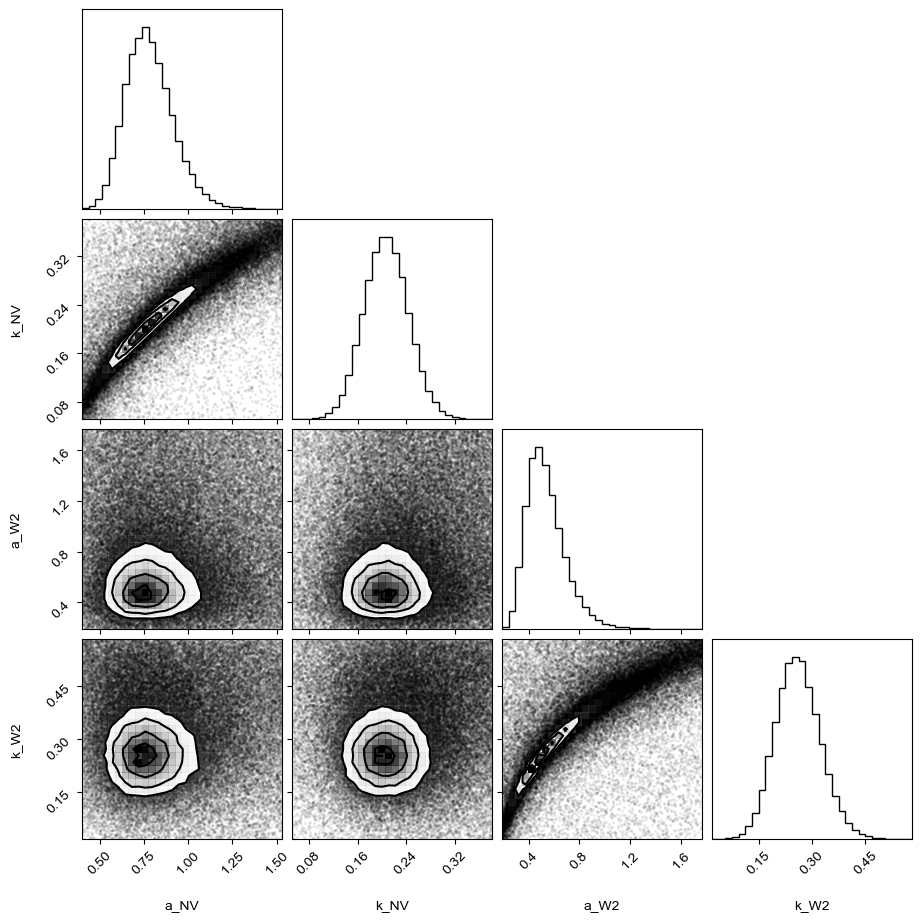

In [9]:
# Estimate evidence for Model 3 (different decay rates and initial values)
def model3(theta, x):
    a_NV, k_NV, a_W2, k_W2 = theta
    
    model_y = a_NV * np.exp(-k_NV * x[:, 0]) * (x[:, 1] == 0) + a_W2 * np.exp(-k_W2 * x[:, 0]) * (x[:, 1] == 1)
   
    return model_y
# Combine NV and W2 data
x_NV = np.column_stack((nv_time_points, np.zeros_like(nv_time_points)))  # Group 0 for NV
x_W2 = np.column_stack((w2_time_points, np.ones_like(w2_time_points)))  # Group 1 for W2
x_combined = np.vstack((x_NV, x_W2))
y_combined = np.concatenate((NV_data, W2_data))
# Estimate yerr as the standard deviation at each time point
yerr_combined = np.concatenate((NV_std, W2_std))


# The likelihood function:
def loglike(theta):
    return -0.5*(np.sum((y_combined-model3(theta, x_combined))**2/yerr_combined**2))
# Defines a flat prior in 0 < m < 1, 0 < a < 2:
def prior_transform(theta):
    return np.array([2., 1., 2., 1.]) * theta
ndim = 4  # number of parameters

# Run nested sampling
res = nestle.sample(loglike, prior_transform, ndim, method='single',
                    npoints=10000, callback=nestle.print_progress)
print(res.summary())
# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)
print("a_NV = {0:5.2f} +/- {1:5.2f}".format(p[0], np.sqrt(cov[0, 0])))
print("k_NV = {0:5.2f} +/- {1:5.2f}".format(p[1], np.sqrt(cov[1, 1])))
print("a_W2 = {0:5.2f} +/- {1:5.2f}".format(p[2], np.sqrt(cov[2, 2])))
print("k_W2 = {0:5.2f} +/- {1:5.2f}".format(p[3], np.sqrt(cov[3, 3])))
# Compute the half-life and its error for both NV and 2W
decay_constant_NV = p[1]
half_life_NV = np.log(2) / decay_constant_NV
half_life_NV_error = np.log(2) / (decay_constant_NV**2) * np.sqrt(cov[1, 1])
print("NV Half-life = {0:5.2f} +/- {1:5.2f}".format(half_life_NV, half_life_NV_error))
decay_constant_W2 = p[3]
half_life_W2 = np.log(2) / decay_constant_W2
half_life_W2_error = np.log(2) / (decay_constant_W2**2) * np.sqrt(cov[3, 3])
print("W2 Half-life = {0:5.2f} +/- {1:5.2f}".format(half_life_W2, half_life_W2_error))
#%% Plot the corner plot for the parameters
fig = corner.corner(res.samples, weights=res.weights, labels=['a_NV', 'k_NV', 'a_W2', 'k_W2'],
                    range=[0.9999, 0.99999, 0.9999, 0.99999], bins=30)

### Run nested sampling for Model 4 with Expt 2 FLC data

it=132374 logz=-394.01115621niter: 132375
ncall: 254243
nsamples: 142375
logz: -393.654 +/-  0.033
h: 10.956
a_NV =  1.15 +/-  0.03
a_W2 =  0.76 +/-  0.02
k =  0.16 +/-  0.01
Half-life =  4.42 +/-  0.17


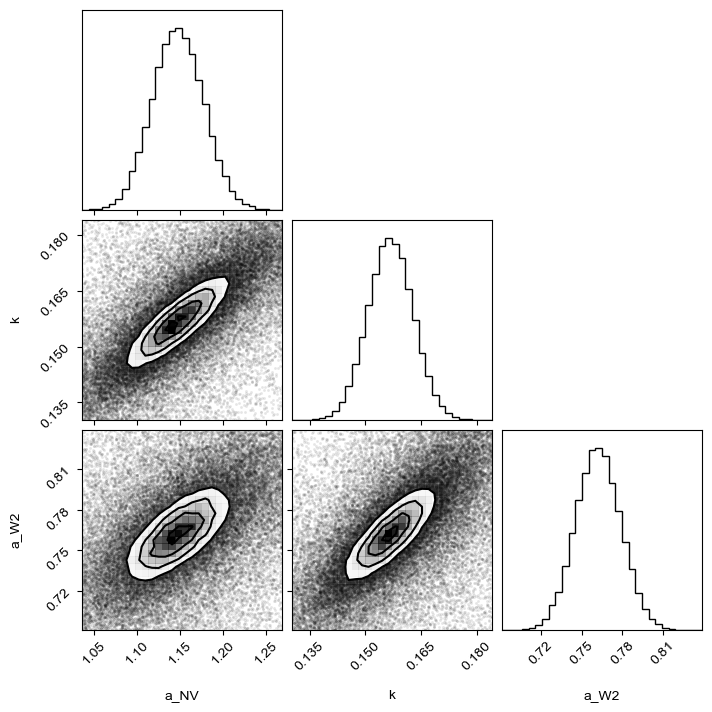

In [7]:
# Estimate evidence for Model 4 (same decay rates but different initial values)
def model4(theta, x):
    a_NV, k, a_W2 = theta
    
    model_y = a_NV * np.exp(-k * x[:, 0]) * (x[:, 1] == 0) + a_W2 * np.exp(-k * x[:, 0]) * (x[:, 1] == 1)
   
    return model_y
# The likelihood function:
def loglike(theta):
    return -0.5*(np.sum((y_combined-model4(theta, x_combined))**2/yerr_combined**2))
# Defines a flat prior in 0 < m < 1, 0 < a < 2:
def prior_transform(theta):
    return np.array([2., 2., 1.]) * theta
ndim = 3  # number of parameters
# Run nested sampling
res = nestle.sample(loglike, prior_transform, ndim, method='single',
                    npoints=10000, callback=nestle.print_progress)
print(res.summary())    
# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)
print("a_NV = {0:5.2f} +/- {1:5.2f}".format(p[0], np.sqrt(cov[0, 0])))
print("a_W2 = {0:5.2f} +/- {1:5.2f}".format(p[2], np.sqrt(cov[2, 2])))
print("k = {0:5.2f} +/- {1:5.2f}".format(p[1], np.sqrt(cov[1, 1])))
# Compute the half-life and its error
decay_constant = p[1]
half_life = np.log(2) / decay_constant
half_life_error = np.log(2) / (decay_constant**2) * np.sqrt(cov[1, 1])
print("Half-life = {0:5.2f} +/- {1:5.2f}".format(half_life, half_life_error))
#%% Plot the corner plot for the parameters
fig = corner.corner(res.samples, weights=res.weights, labels=['a_NV', 'k','a_W2',],
                    range=[0.9999, 0.99999, 0.99999], bins=30)
plt.show()



# The above analysis gives a Bayes factor (Evidence for Model 3/ Evidence for model 4) of $ B \approx e^{-1.44} \approx 0.24 $, which moderately favours Model 4 over Model 3, hence indicating no significant change in decay rate between NV and 1W for FLC.

# For Expt 2 PP2A data, analyse the difference between NV and 1W decay rates by comparing the Bayesian evidence for two models: 
# (Model 4) with same value of decay rate parameter in both conditions, 
# (Model 3) with different values of decay rate parameter in NV and 1W conditions 

### Import Expt 2 PP2A data, specify Model 3, and run nested sampling for Model 3

it= 87620 logz=-95.3402308917niter: 87621
ncall: 1632958
nsamples: 97621
logz: -95.061 +/-  0.024
h:  5.936
a_NV =  0.53 +/-  0.27
k_NV =  0.51 +/-  0.10
a_W2 =  0.83 +/-  0.41
k_W2 =  0.78 +/-  0.12
NV Half-life =  1.37 +/-  0.27
W2 Half-life =  0.89 +/-  0.14


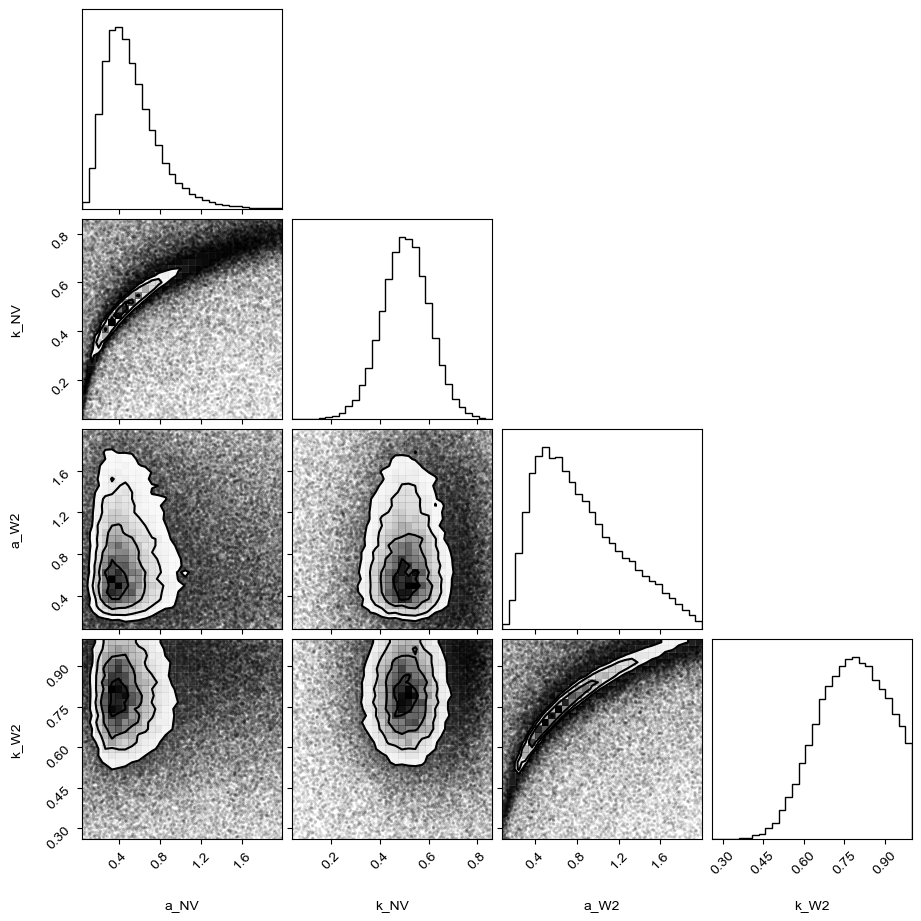

In [ ]:
# Perform nested sampling with zero-asymptote model for NV and 1W together, allowing different decay rates and intial values (Model 2)
# Import data (counts per unit area per cell) from Excel file for smFISH Expt 2
file_path = 'FLC_mRNA_ActD_Decay_Exp2_Dataset.xlsx'
df_pp2a = pd.read_excel(file_path, sheet_name='PP2A Summary', engine='openpyxl')

# Extract the first 3 columns to make the NV data table
NV_df_pp2a = df_pp2a.iloc[:, 0:3]
# Extract the last 3 columns to make the W2 data table
W2_df_pp2a = df_pp2a.iloc[:, 3:]

# Extract the non-NaN values for the 4h time point into an array
NV_4h = NV_df_pp2a.iloc[:, 1].dropna().values
# Estimate the NV_4h standard deviation
NV_4h_std = np.std(NV_4h)
# Extract the non-NaN values for the 6h time point into an array
NV_6h = NV_df_pp2a.iloc[:, 2].dropna().values
# Estimate the NV_6h standard deviation
NV_6h_std = np.std(NV_6h)
# Combine only the 4h and 6h arrays into a single vertical array
NV_data = np.concatenate((NV_4h, NV_6h))
# Put the corresponding standard deviations into a single vertical array
NV_std = np.concatenate((np.full(NV_4h.shape, NV_4h_std), np.full(NV_6h.shape, NV_6h_std)))
# Create an array of time points corresponding to the data
nv_time_points = np.concatenate((np.full(NV_4h.shape, 4), np.full(NV_6h.shape, 6)))

# Repeat for W2 
# Extract the non-NaN values for the 4h time point into an array
W2_4h = W2_df_pp2a.iloc[:, 1].dropna().values
# Estimate the W2_4h standard deviation
W2_4h_std = np.std(W2_4h)
# Extract the non-NaN values for the 6h time point into an array
W2_6h = W2_df_pp2a.iloc[:, 2].dropna().values
# Estimate the W2_6h standard deviation
W2_6h_std = np.std(W2_6h)
# Combine only the 4h and 6h arrays into a single vertical array
W2_data = np.concatenate((W2_4h, W2_6h))
# Put the corresponding standard deviations into a single vertical array
W2_std = np.concatenate((np.full(W2_4h.shape, W2_4h_std), np.full(W2_6h.shape, W2_6h_std)))
# Create an array of time points corresponding to the data
w2_time_points = np.concatenate((np.full(W2_4h.shape, 4), np.full(W2_6h.shape, 6)))

# Estimate evidence for Model 3 (different decay rates and initial values)
def model3(theta, x):
    a_NV, k_NV, a_W2, k_W2 = theta
    
    model_y = a_NV * np.exp(-k_NV * x[:, 0]) * (x[:, 1] == 0) + a_W2 * np.exp(-k_W2 * x[:, 0]) * (x[:, 1] == 1)
   
    return model_y
# Combine NV and W2 data
x_NV = np.column_stack((nv_time_points, np.zeros_like(nv_time_points)))  # Group 0 for NV
x_W2 = np.column_stack((w2_time_points, np.ones_like(w2_time_points)))  # Group 1 for W2
x_combined = np.vstack((x_NV, x_W2))
y_combined = np.concatenate((NV_data, W2_data))
# Estimate yerr as the standard deviation at each time point
yerr_combined = np.concatenate((NV_std, W2_std))
# The likelihood function:
def loglike(theta):
    return -0.5*(np.sum((y_combined-model3(theta, x_combined))**2/yerr_combined**2))
# Defines a flat prior in 0 < m < 1, 0 < a < 2:
def prior_transform(theta):
    return np.array([2., 1., 2., 1.]) * theta
ndim = 4  # number of parameters

# Run nested sampling
res = nestle.sample(loglike, prior_transform, ndim, method='single',
                    npoints=10000, callback=nestle.print_progress)
print(res.summary())
# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)
print("a_NV = {0:5.2f} +/- {1:5.2f}".format(p[0], np.sqrt(cov[0, 0])))
print("k_NV = {0:5.2f} +/- {1:5.2f}".format(p[1], np.sqrt(cov[1, 1])))
print("a_W2 = {0:5.2f} +/- {1:5.2f}".format(p[2], np.sqrt(cov[2, 2])))
print("k_W2 = {0:5.2f} +/- {1:5.2f}".format(p[3], np.sqrt(cov[3, 3])))
# Compute the half-life and its error for both NV and 2W
decay_constant_NV = p[1]
half_life_NV = np.log(2) / decay_constant_NV
half_life_NV_error = np.log(2) / (decay_constant_NV**2) * np.sqrt(cov[1, 1])
print("NV Half-life = {0:5.2f} +/- {1:5.2f}".format(half_life_NV, half_life_NV_error))
decay_constant_W2 = p[3]
half_life_W2 = np.log(2) / decay_constant_W2
half_life_W2_error = np.log(2) / (decay_constant_W2**2) * np.sqrt(cov[3, 3])
print("W2 Half-life = {0:5.2f} +/- {1:5.2f}".format(half_life_W2, half_life_W2_error))
#%% Plot the corner plot for the parameters
fig = corner.corner(res.samples, weights=res.weights, labels=['a_NV', 'k_NV', 'a_W2', 'k_W2'],
                    range=[0.9999, 0.99999, 0.9999, 0.99999], bins=30)

### Run nested sampling for Model 4 with Expt 2 PP2A data

it= 82739 logz=-95.9225022205niter: 82740
ncall: 648754
nsamples: 92740
logz: -95.583 +/-  0.024
h:  5.736
a_NV =  0.82 +/-  0.30
a_W2 =  0.37 +/-  0.13
k =  0.61 +/-  0.07
Half-life =  1.15 +/-  0.14


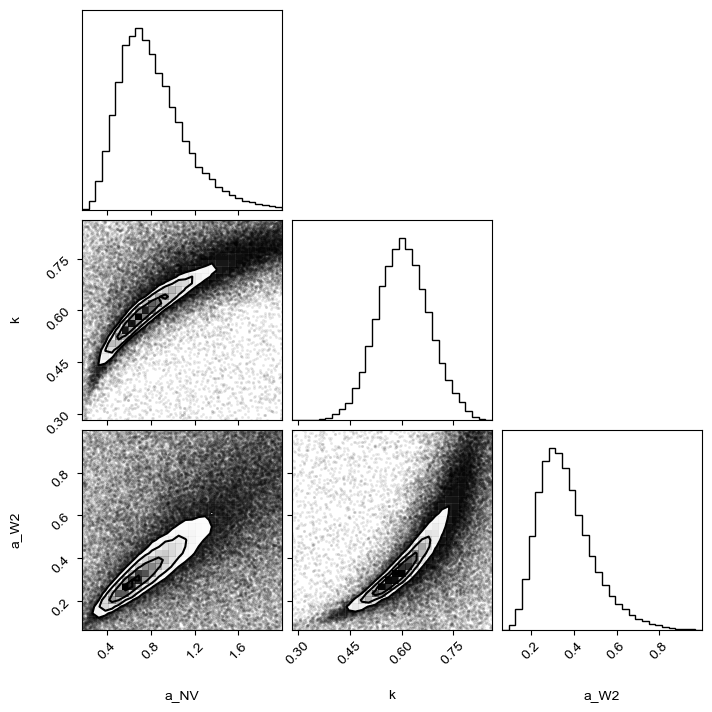

In [9]:
# Estimate evidence for Model 4 (same decay rates but different initial values)
def model4(theta, x):
    a_NV, k, a_W2 = theta
    
    model_y = a_NV * np.exp(-k * x[:, 0]) * (x[:, 1] == 0) + a_W2 * np.exp(-k * x[:, 0]) * (x[:, 1] == 1)
   
    return model_y
# The likelihood function:
def loglike(theta):
    return -0.5*(np.sum((y_combined-model4(theta, x_combined))**2/yerr_combined**2))
# Defines a flat prior in 0 < m < 1, 0 < a < 2:
def prior_transform(theta):
    return np.array([2., 2., 1.]) * theta
ndim = 3  # number of parameters
# Run nested sampling
res = nestle.sample(loglike, prior_transform, ndim, method='single',
                    npoints=10000, callback=nestle.print_progress)
print(res.summary())    
# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)
print("a_NV = {0:5.2f} +/- {1:5.2f}".format(p[0], np.sqrt(cov[0, 0])))
print("a_W2 = {0:5.2f} +/- {1:5.2f}".format(p[2], np.sqrt(cov[2, 2])))
print("k = {0:5.2f} +/- {1:5.2f}".format(p[1], np.sqrt(cov[1, 1])))
# Compute the half-life and its error
decay_constant = p[1]
half_life = np.log(2) / decay_constant
half_life_error = np.log(2) / (decay_constant**2) * np.sqrt(cov[1, 1])
print("Half-life = {0:5.2f} +/- {1:5.2f}".format(half_life, half_life_error))
#%% Plot the corner plot for the parameters
fig = corner.corner(res.samples, weights=res.weights, labels=['a_NV', 'k', 'a_W2'],
                    range=[0.9999, 0.99999, 0.99999], bins=30)
plt.show()

# The above analysis gives a Bayes factor (Evidence for Model 3/ Evidence for model 4) of $ B \approx e^{0.55} \approx 1.73 $, which only weakly favours Model 3 over Model 4, indicating no significant evidence of decay rate change between NV and 1W for PP2A.

# Compare NV FLC to W2 PP2A using Model 3 and Model 4 to show that the Bayes factor can distinguish significantly different decay rates from the data

it=102003 logz=-96.7766446219niter: 102004
ncall: 1402244
nsamples: 112004
logz: -96.488 +/-  0.027
h:  7.472
a_NV =  0.78 +/-  0.13
k_NV =  0.21 +/-  0.04
a_W2 =  0.83 +/-  0.41
k_W2 =  0.78 +/-  0.12
NV Half-life =  3.35 +/-  0.59
W2 Half-life =  0.89 +/-  0.14


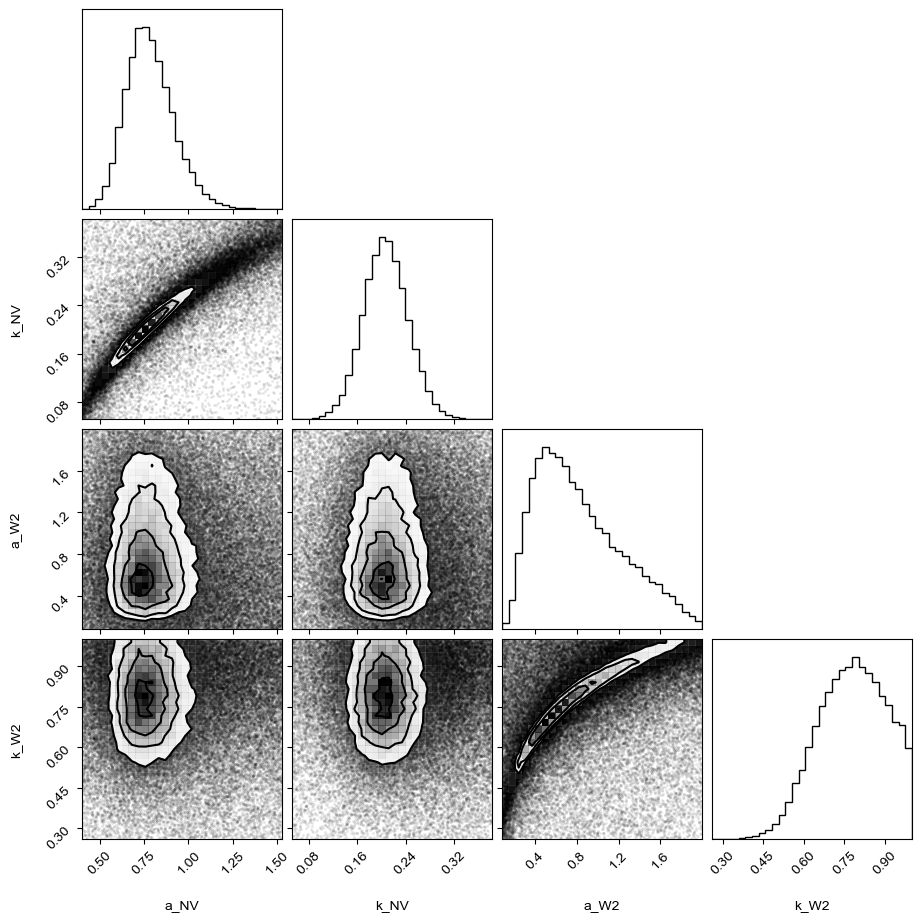

In [ ]:
# Import data (counts per unit area per cell) from Excel file for smFISH Expt 2
file_path = 'FLC_mRNA_ActD_Decay_Exp2_Dataset.xlsx'
df_flc = pd.read_excel(file_path, sheet_name='FLC Summary', engine='openpyxl')

# Extract the first 3 columns to make the NV data table
NV_df_flc = df_flc.iloc[:, 0:3]
# Extract the last 3 columns to make the W2 data table
W2_df_flc = df_flc.iloc[:, 3:]

df_pp2a = pd.read_excel(file_path, sheet_name='PP2A Summary', engine='openpyxl')
# Extract the first 3 columns to make the NV data table
NV_df_pp2a = df_pp2a.iloc[:, 0:3]
# Extract the last 3 columns to make the W2 data table
W2_df_pp2a = df_pp2a.iloc[:, 3:]


# Extract the non-NaN values for the 4h time point into an array
NV_4h = NV_df_flc.iloc[:, 1].dropna().values
# Estimate the NV_4h standard deviation
NV_4h_std = np.std(NV_4h)
# Extract the non-NaN values for the 6h time point into an array
NV_6h = NV_df_flc.iloc[:, 2].dropna().values
# Estimate the NV_6h standard deviation
NV_6h_std = np.std(NV_6h)


# Combine only the 4h and 6h arrays into a single vertical array
NV_data = np.concatenate((NV_4h, NV_6h))
# Put the corresponding standard deviations into a single vertical array
NV_std = np.concatenate((np.full(NV_4h.shape, NV_4h_std), np.full(NV_6h.shape, NV_6h_std)))
# Create an array of time points corresponding to the data
nv_time_points = np.concatenate((np.full(NV_4h.shape, 4), np.full(NV_6h.shape, 6)))

# Repeat for W2 
# Extract the non-NaN values for the 4h time point into an array
W2_4h = W2_df_pp2a.iloc[:, 1].dropna().values
# Estimate the W2_4h standard deviation
W2_4h_std = np.std(W2_4h)
# Extract the non-NaN values for the 6h time point into an array
W2_6h = W2_df_pp2a.iloc[:, 2].dropna().values
# Estimate the W2_6h standard deviation
W2_6h_std = np.std(W2_6h)
# Combine only the 4h and 6h arrays into a single vertical array
W2_data = np.concatenate((W2_4h, W2_6h))
# Put the corresponding standard deviations into a single vertical array
W2_std = np.concatenate((np.full(W2_4h.shape, W2_4h_std), np.full(W2_6h.shape, W2_6h_std)))
# Create an array of time points corresponding to the data
w2_time_points = np.concatenate((np.full(W2_4h.shape, 4), np.full(W2_6h.shape, 6)))

# Estimate evidence for Model 3 (different decay rates and initial values)
def model3(theta, x):
    a_NV, k_NV, a_W2, k_W2 = theta
    
    model_y = a_NV * np.exp(-k_NV * x[:, 0]) * (x[:, 1] == 0) + a_W2 * np.exp(-k_W2 * x[:, 0]) * (x[:, 1] == 1)
   
    return model_y
# Combine NV and W2 data
x_NV = np.column_stack((nv_time_points, np.zeros_like(nv_time_points)))  # Group 0 for NV
x_W2 = np.column_stack((w2_time_points, np.ones_like(w2_time_points)))  # Group 1 for W2
x_combined = np.vstack((x_NV, x_W2))
y_combined = np.concatenate((NV_data, W2_data))
# Estimate yerr as the standard deviation at each time point
yerr_combined = np.concatenate((NV_std, W2_std))
# The likelihood function:
def loglike(theta):
    return -0.5*(np.sum((y_combined-model3(theta, x_combined))**2/yerr_combined**2))
# Defines a flat prior in 0 < m < 1, 0 < a < 2:
def prior_transform(theta):
    return np.array([2., 1., 2., 1.]) * theta
ndim = 4  # number of parameters

# Run nested sampling
res = nestle.sample(loglike, prior_transform, ndim, method='single',
                    npoints=10000, callback=nestle.print_progress)
print(res.summary())
# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)
print("a_NV = {0:5.2f} +/- {1:5.2f}".format(p[0], np.sqrt(cov[0, 0])))
print("k_NV = {0:5.2f} +/- {1:5.2f}".format(p[1], np.sqrt(cov[1, 1])))
print("a_W2 = {0:5.2f} +/- {1:5.2f}".format(p[2], np.sqrt(cov[2, 2])))
print("k_W2 = {0:5.2f} +/- {1:5.2f}".format(p[3], np.sqrt(cov[3, 3])))
# Compute the half-life and its error for both NV and 2W
decay_constant_NV = p[1]
half_life_NV = np.log(2) / decay_constant_NV
half_life_NV_error = np.log(2) / (decay_constant_NV**2) * np.sqrt(cov[1, 1])
print("NV Half-life = {0:5.2f} +/- {1:5.2f}".format(half_life_NV, half_life_NV_error))
decay_constant_W2 = p[3]
half_life_W2 = np.log(2) / decay_constant_W2
half_life_W2_error = np.log(2) / (decay_constant_W2**2) * np.sqrt(cov[3, 3])
print("W2 Half-life = {0:5.2f} +/- {1:5.2f}".format(half_life_W2, half_life_W2_error))
#%% Plot the corner plot for the parameters
fig = corner.corner(res.samples, weights=res.weights, labels=['a_NV', 'k_NV', 'a_W2', 'k_W2'],
                    range=[0.9999, 0.99999, 0.9999, 0.99999], bins=30)



it=111646 logz=-106.329417171niter: 111647
ncall: 533596
nsamples: 121647
logz: -105.975 +/-  0.030
h:  8.801
a_NV =  1.01 +/-  0.18
a_W2 =  0.07 +/-  0.02
k =  0.26 +/-  0.04
Half-life =  2.63 +/-  0.38


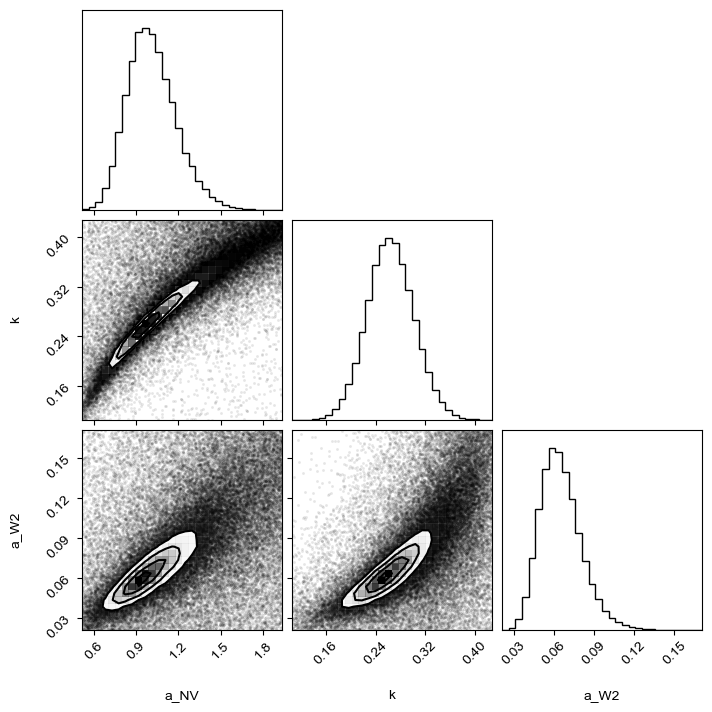

In [22]:
# Estimate evidence for Model 4 (same decay rates but different initial values)
def model4(theta, x):
    a_NV, k, a_W2 = theta
    
    model_y = a_NV * np.exp(-k * x[:, 0]) * (x[:, 1] == 0) + a_W2 * np.exp(-k * x[:, 0]) * (x[:, 1] == 1)
   
    return model_y
# The likelihood function:
def loglike(theta):
    return -0.5*(np.sum((y_combined-model4(theta, x_combined))**2/yerr_combined**2))
# Defines a flat prior in 0 < m < 1, 0 < a < 2:
def prior_transform(theta):
    return np.array([2., 2., 1.]) * theta
ndim = 3  # number of parameters
# Run nested sampling
res = nestle.sample(loglike, prior_transform, ndim, method='single',
                    npoints=10000, callback=nestle.print_progress)
print(res.summary())    
# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)
print("a_NV = {0:5.2f} +/- {1:5.2f}".format(p[0], np.sqrt(cov[0, 0])))
print("a_W2 = {0:5.2f} +/- {1:5.2f}".format(p[2], np.sqrt(cov[2, 2])))
print("k = {0:5.2f} +/- {1:5.2f}".format(p[1], np.sqrt(cov[1, 1])))
# Compute the half-life and its error
decay_constant = p[1]
half_life = np.log(2) / decay_constant
half_life_error = np.log(2) / (decay_constant**2) * np.sqrt(cov[1, 1])
print("Half-life = {0:5.2f} +/- {1:5.2f}".format(half_life, half_life_error))
#%% Plot the corner plot for the parameters
fig = corner.corner(res.samples, weights=res.weights, labels=['a_NV', 'k', 'a_W2'],
                    range=[0.9999, 0.99999, 0.99999], bins=30)
plt.show()

# The above analysis shows that when comparing NV FLC to W2 PP2A mRNA decay rates, the Bayes factor (Evidence for Model 3/ Evidence for model 4) is $ B \approx e^{10}$, favouring Model 3 over Model 4, providing decisive evidence for Model 3 which has different decay rates.